This notebook attempts to study the kinematics of the cloud. It actually starts with a bunch of figures trying to make the velocity and velocity dispersion maps took paper-ready. We also learned to rotate the data, so this notebook has all the rotated analysis. This came out to some density profiles and then some analysis of the velocity gradients of G1 and G2. It ends with the radial arrow -- line of sight velocity gradient model. 

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
import astropy
import astropy.units as u
import astropy.constants as c
from astropy import wcs
from spectral_cube import SpectralCube
from importlib import reload
from photutils import find_peaks
import r_mod
import matplotlib.gridspec as gridspec
import time
from fractions import Fraction
import os
import column_density as cd
from scipy.optimize import curve_fit
from scipy import ndimage, misc
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
import FITS_tools
import pandas as pd

In [2]:
r_mod = reload(r_mod)
cd = reload(cd)

## Load in Relevant Data

In [27]:
tmc1_hdu = fits.open('tmc1_ls.fits')
ls_hdu = fits.open('ls.fits')

hdul2 = fits.open('/Users/simonsmith/Documents/SURP/Data/HC2_HC5N_all_rebase3_mom0_QA_trim.fits')
coord_head = hdul2[0].header

ls_tmc1 = Cutout2D(hdul2[0].data, position=(60, 165), size=(70, 60), wcs=wcs.WCS(coord_head))
test_header = ls_tmc1.wcs.to_header()
test_header['NAXIS1'] = 60
test_header['NAXIS2'] = 70

cube_data = tmc1_hdu[0].data



g1_intensity, g2_intensity, g3_intensity = tmc1_hdu[1].data, tmc1_hdu[2].data, tmc1_hdu[3].data
g1_velocity, g2_velocity, g3_velocity = tmc1_hdu[4].data, tmc1_hdu[5].data, tmc1_hdu[6].data
g1_dispersion, g2_dispersion, g3_dispersion = tmc1_hdu[7].data, tmc1_hdu[8].data, tmc1_hdu[9].data

pix_scale_au = (((test_header['CDELT2']*u.deg).to(u.rad))/u.rad*140*u.pc).to(u.au)



In [29]:
hdul = fits.open('/Users/simonsmith/Documents/SURP/Data/TauTMC_colden_500_reso_masked.fits')
colden_head = hdul[0].header
colden_data = hdul[0].data

ls_head = ls_hdu[1].header

sizera = float((ls_head['NAXIS1']*ls_head['CDELT2']*u.deg).to(u.arcmin)/u.arcmin)
sizedec = float((ls_head['NAXIS2']*ls_head['CDELT2']*u.deg).to(u.arcmin)/u.arcmin)

colden_w = wcs.WCS(colden_head)
tmc1ctr = SkyCoord('4h41m42.3s 25d40m56.34247s', frame='fk5')
size = u.Quantity((sizedec, sizera), u.arcmin)


tmc1 = Cutout2D(colden_data,position=tmc1ctr,size=size,wcs=colden_w)

colden_mask = tmc1.data > 1e22
g_colden = np.empty(colden_mask.shape)
g_colden.fill(np.nan)
g_colden[colden_mask == True] = 1

colden_re = FITS_tools.hcongrid.hcongrid(colden_data,colden_head,test_header)


In [30]:
#TMC-1 Lower Section Masks

ls_mask1 = g1_intensity > 0.03
ls_g1 = np.empty(ls_mask1.shape)
ls_g1.fill(np.nan)
ls_g1[ls_mask1 == True] = 1

ls_mask2 = g2_intensity > 0.08
ls_g2 = np.empty(ls_mask2.shape)
ls_g2.fill(np.nan)
ls_g2[ls_mask2 == True] = 1

ls_mask3 = g3_intensity > 0.05 
ls_g3 = np.empty(ls_mask3.shape)
ls_g3.fill(np.nan)
ls_g3[ls_mask3 == True] = 1

total_int = g1_intensity+g2_intensity+g3_intensity
ls_maskt = total_int > 0.16
ls_gt = np.empty(ls_maskt.shape)
ls_gt.fill(np.nan)
ls_gt[ls_maskt == True] = 1

In [6]:
disp_max = np.max(g1_dispersion)
disp_max

0.5701909458553851

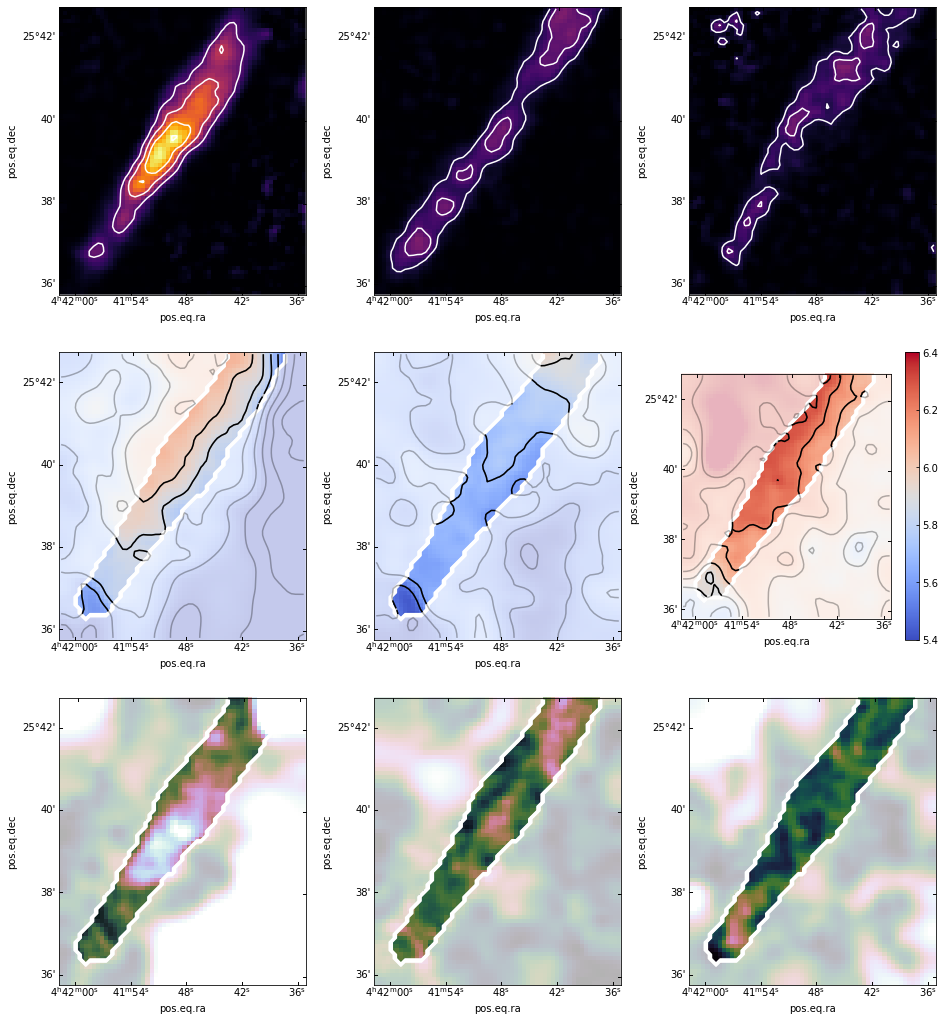

In [6]:
fig = plt.figure(figsize=(16, 18), constrained_layout=False)
levels=np.arange(5.4, 6.4, 0.1)
int_max = np.max(g1_intensity)
disp_max = np.max(g1_dispersion)

#----------------------------------------------------------------------------

ax1 = fig.add_subplot(331, projection=tmc1.wcs)

ax1.imshow(g1_intensity, cmap='inferno', vmax=int_max)
#ax1.contour(ls_maskt, colors='white', alpha=0.6)
ax1.contour(g1_intensity, colors='white', levels=[0.2, 0.4, 0.6, 0.8])

#----------------------------------------------------------------------------

ax2 = fig.add_subplot(332, projection=tmc1.wcs)

ax2.imshow(g2_intensity, cmap='inferno', vmax=int_max)
#ax2.contour(ls_maskt, colors='white', alpha=0.6)
ax2.contour(g2_intensity, colors='white', levels=[0.1, 0.2 , 0.3, 0.4])

#----------------------------------------------------------------------------

ax3 = fig.add_subplot(333, projection=tmc1.wcs)

im1 = ax3.imshow(2*g3_intensity, cmap='inferno', vmax=int_max) #multiplied by 2 for visibility
#ax3.contour(ls_maskt, colors='white', alpha=0.6)
ax3.contour(g3_intensity, colors='white', levels=[0.05, 0.1, 0.15, 0.2, 0.25])


p1 = ax1.get_position().get_points().flatten()
p2 = ax2.get_position().get_points().flatten()
p3 = ax3.get_position().get_points().flatten()

#ax_cbar1 = fig.add_axes([p1[0], 2/3, p3[2]-p1[0], 0.01])
#plt.colorbar(im1, cax=ax_cbar1, orientation='horizontal')

#----------------------------------------------------------------------------

ax4 = fig.add_subplot(334, projection=tmc1.wcs)

ax4.imshow(ls_gt*g1_velocity, cmap='coolwarm', vmin=5.4, vmax=6.4)
ax4.imshow(g1_velocity, cmap='coolwarm', vmin=5.6, vmax=6.4 , alpha=0.3)
ax4.contour(ls_maskt, colors='white')
ax4.contour(ls_gt*g1_velocity, colors='black', levels=levels)
ax4.contour(g1_velocity, colors='black', alpha=0.3, levels=levels)

#----------------------------------------------------------------------------

ax5 = fig.add_subplot(335, projection=tmc1.wcs)

ax5.imshow(ls_gt*g2_velocity, cmap='coolwarm', vmin=5.4, vmax=6.4)
ax5.imshow(g2_velocity, cmap='coolwarm', vmin=5.4, vmax=6.4 , alpha=0.3)
ax5.contour(ls_maskt, colors='white')
ax5.contour(ls_gt*g2_velocity, colors='black', levels=levels)
ax5.contour(g2_velocity, colors='black', alpha=0.3, levels=levels)

#----------------------------------------------------------------------------

ax6 = fig.add_subplot(336, projection=tmc1.wcs)

im2 = ax6.imshow(ls_gt*g3_velocity, cmap='coolwarm', vmin=5.4, vmax=6.4)
ax6.imshow(g3_velocity, cmap='coolwarm', vmin=5.4, vmax=6.4 , alpha=0.3)
ax6.contour(ls_maskt, colors='white')
ax6.contour(ls_gt*g3_velocity, colors='black', levels=levels)
ax6.contour(g3_velocity, colors='black', alpha=0.3, levels=levels)
cbar = plt.colorbar(im2)

#----------------------------------------------------------------------------

ax7 = fig.add_subplot(337, projection=tmc1.wcs)

ax7.imshow(ls_gt*g1_dispersion, cmap='cubehelix', vmax=1/3*disp_max)
ax7.imshow(g1_dispersion, cmap='cubehelix', alpha=0.3, vmax=1/3*disp_max)
ax7.contour(ls_maskt, colors='white')

#----------------------------------------------------------------------------

ax8 = fig.add_subplot(338, projection=tmc1.wcs)

ax8.imshow(ls_gt*g2_dispersion, cmap='cubehelix', vmax=1/3*disp_max)
ax8.imshow(g2_dispersion, cmap='cubehelix', alpha=0.3, vmax=1/3*disp_max)
ax8.contour(ls_maskt, colors='white')

#----------------------------------------------------------------------------

ax9 = fig.add_subplot(339, projection=tmc1.wcs)

im3 = ax9.imshow(ls_gt*g3_dispersion, cmap='cubehelix', vmax=1/3*disp_max)
ax9.imshow(g3_dispersion, cmap='cubehelix', alpha=0.3, vmax=1/3*disp_max)
ax9.contour(ls_maskt, colors='white')


#ax_cbar3 = fig.add_axes(0, 0, 1, 0.1)
#plt.colorbar(im3, cax=ax_cbar3, orientation='horizontal')


plt.show()

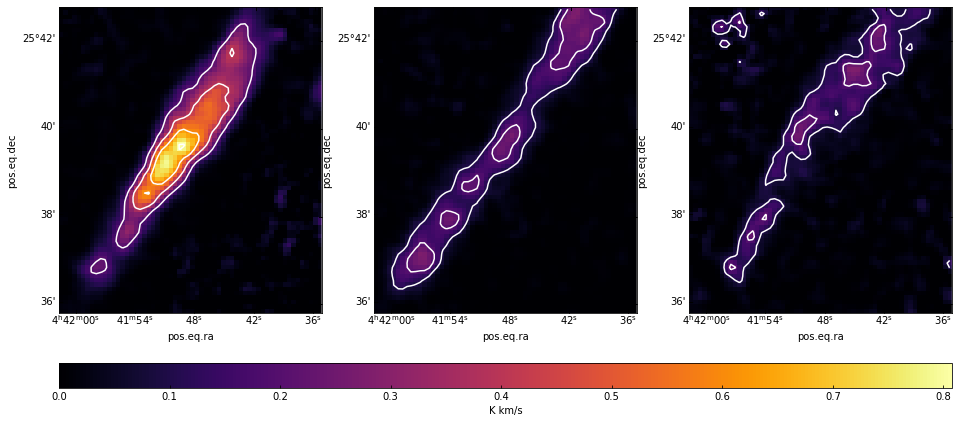

In [12]:
fig = plt.figure(figsize=(16, 7))

#----------------------------------------------------------------------------

ax1 = fig.add_subplot(131, projection=tmc1.wcs)

ax1.imshow(g1_intensity, cmap='inferno', vmax=int_max)
#ax1.contour(ls_maskt, colors='white', alpha=0.6)
ax1.contour(g1_intensity, colors='white', levels=[0.2, 0.4, 0.6, 0.8])

#----------------------------------------------------------------------------

ax2 = fig.add_subplot(132, projection=tmc1.wcs)

ax2.imshow(g2_intensity, cmap='inferno', vmax=int_max)
#ax2.contour(ls_maskt, colors='white', alpha=0.6)
ax2.contour(g2_intensity, colors='white', levels=[0.1, 0.2 , 0.3, 0.4])

#----------------------------------------------------------------------------

ax3 = fig.add_subplot(133, projection=tmc1.wcs)

im1 = ax3.imshow(2*g3_intensity, cmap='inferno', vmax=int_max) #multiplied by 2 for visibility
#ax3.contour(ls_maskt, colors='white', alpha=0.6)
ax3.contour(g3_intensity, colors='white', levels=[0.05, 0.1, 0.15, 0.2, 0.25])

p1 = ax1.get_position().get_points().flatten()
p2 = ax2.get_position().get_points().flatten()
p3 = ax3.get_position().get_points().flatten()

ax_cbar1 = fig.add_axes([p1[0], 0.05, p3[2]-p1[0], 0.05])
plt.colorbar(im1, cax=ax_cbar1, orientation='horizontal', label='K km/s')

plt.show()

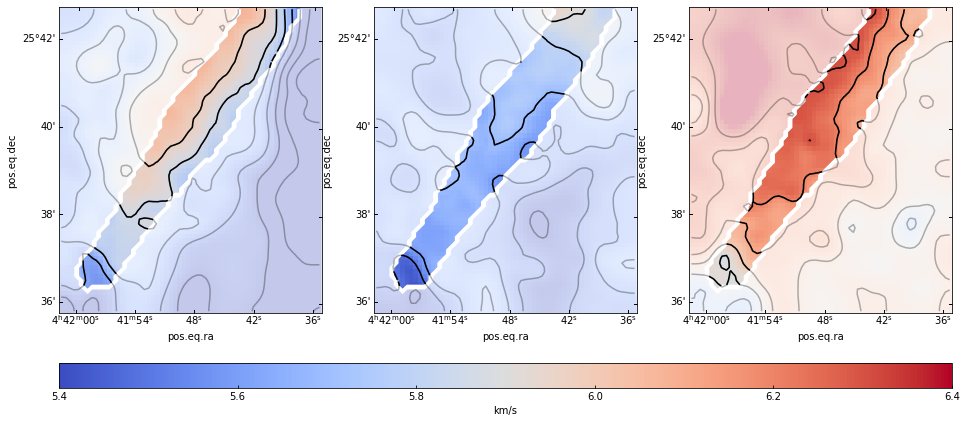

In [18]:
fig = plt.figure(figsize=(16, 7))
levels=np.arange(5.4, 6.4, 0.1)

#----------------------------------------------------------------------------

ax1 = fig.add_subplot(131, projection=tmc1.wcs)

ax1.imshow(ls_gt*g1_velocity, cmap='coolwarm', vmin=5.4, vmax=6.4)
ax1.imshow(g1_velocity, cmap='coolwarm', vmin=5.6, vmax=6.4 , alpha=0.3)
ax1.contour(ls_maskt, colors='white')
ax1.contour(ls_gt*g1_velocity, colors='black', levels=levels)
ax1.contour(g1_velocity, colors='black', alpha=0.3, levels=levels)

#----------------------------------------------------------------------------

ax2 = fig.add_subplot(132, projection=tmc1.wcs)

ax2.imshow(ls_gt*g2_velocity, cmap='coolwarm', vmin=5.4, vmax=6.4)
ax2.imshow(g2_velocity, cmap='coolwarm', vmin=5.4, vmax=6.4 , alpha=0.3)
ax2.contour(ls_maskt, colors='white')
ax2.contour(ls_gt*g2_velocity, colors='black', levels=levels)
ax2.contour(g2_velocity, colors='black', alpha=0.3, levels=levels)

#----------------------------------------------------------------------------

ax3 = fig.add_subplot(133, projection=tmc1.wcs)

im1 = ax3.imshow(ls_gt*g3_velocity, cmap='coolwarm', vmin=5.4, vmax=6.4)
ax3.imshow(g3_velocity, cmap='coolwarm', vmin=5.4, vmax=6.4 , alpha=0.3)
ax3.contour(ls_maskt, colors='white')
ax3.contour(ls_gt*g3_velocity, colors='black', levels=levels)
ax3.contour(g3_velocity, colors='black', alpha=0.3, levels=levels)

p1 = ax1.get_position().get_points().flatten()
p2 = ax2.get_position().get_points().flatten()
p3 = ax3.get_position().get_points().flatten()

ax_cbar1 = fig.add_axes([p1[0], 0.05, p3[2]-p1[0], 0.05])
plt.colorbar(im1, cax=ax_cbar1, orientation='horizontal', label='km/s')

plt.show()

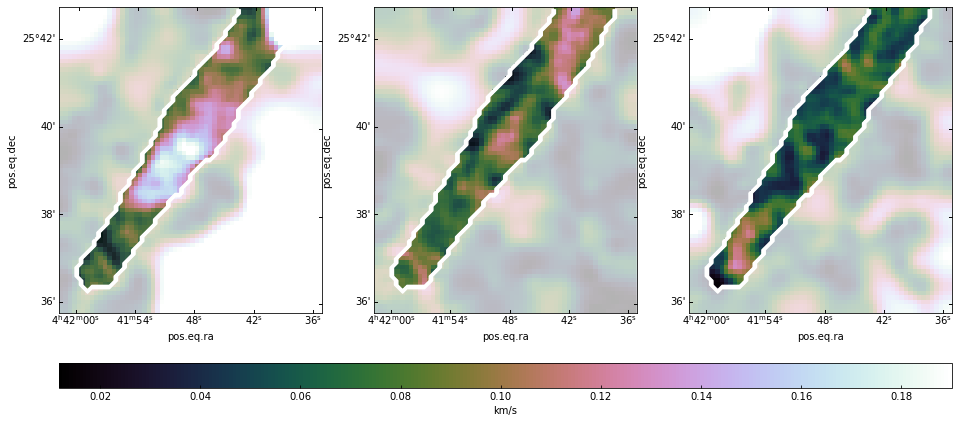

In [23]:
fig = plt.figure(figsize=(16, 7))
disp_max = np.max(g1_dispersion)

#----------------------------------------------------------------------------

ax1 = fig.add_subplot(131, projection=tmc1.wcs)

ax1.imshow(ls_gt*g1_dispersion, cmap='cubehelix', vmax=1/3*disp_max)
ax1.imshow(g1_dispersion, cmap='cubehelix', alpha=0.3, vmax=1/3*disp_max)
ax1.contour(ls_maskt, colors='white')

#----------------------------------------------------------------------------

ax2 = fig.add_subplot(132, projection=tmc1.wcs)

ax2.imshow(ls_gt*g2_dispersion, cmap='cubehelix', vmax=1/3*disp_max)
ax2.imshow(g2_dispersion, cmap='cubehelix', alpha=0.3, vmax=1/3*disp_max)
ax2.contour(ls_maskt, colors='white')

#----------------------------------------------------------------------------

ax3 = fig.add_subplot(133, projection=tmc1.wcs)

im1 = ax3.imshow(ls_gt*g3_dispersion, cmap='cubehelix', vmax=1/3*disp_max)
ax3.imshow(g3_dispersion, cmap='cubehelix', alpha=0.3, vmax=1/3*disp_max)
ax3.contour(ls_maskt, colors='white')

p1 = ax1.get_position().get_points().flatten()
p2 = ax2.get_position().get_points().flatten()
p3 = ax3.get_position().get_points().flatten()

ax_cbar1 = fig.add_axes([p1[0], 0.05, p3[2]-p1[0], 0.05])
plt.colorbar(im1, cax=ax_cbar1, orientation='horizontal', label='km/s')
plt.show()

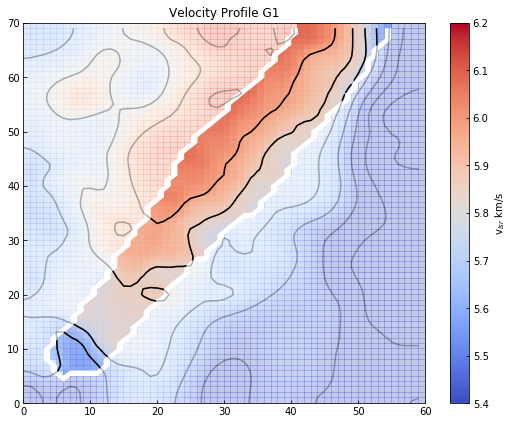

In [9]:
plt.figure(figsize=(9, 7))

levels=np.arange(5.4, 6.2, 0.1)

plt.pcolormesh(ls_gt*g1_velocity, cmap='coolwarm', vmin=5.4, vmax=6.2)
cbar = plt.colorbar()
plt.pcolormesh(g1_velocity, cmap='coolwarm', vmin=5.6, vmax=6.2 , alpha=0.3)
plt.contour(ls_maskt, colors='white')
plt.contour(ls_gt*g1_velocity, colors='black', levels=levels)
plt.contour(g1_velocity, colors='black', alpha=0.3, levels=levels)

#plt.contour(colden_re, colors='purple')

plt.title('Velocity Profile G1')
cbar.set_label('v$_{lsr}$ km/s')
plt.show()



From 6.1 - 5.8

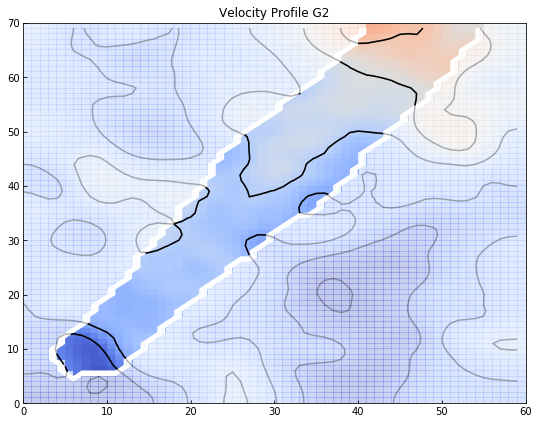

In [10]:
plt.figure(figsize=(9, 7))

levels=np.arange(5.4, 6.2, 0.1)

plt.pcolormesh(ls_gt*g2_velocity, cmap='coolwarm', vmin=5.4, vmax=6.2)
#cbar = plt.colorbar()
plt.pcolormesh(g2_velocity, cmap='coolwarm', vmin=5.4, vmax=6.2 , alpha=0.3)
plt.contour(ls_maskt, colors='white')
plt.contour(ls_gt*g2_velocity, colors='black', levels=levels)
plt.contour(g2_velocity, colors='black', alpha=0.3, levels=levels)

plt.title('Velocity Profile G2')
cbar.set_label('v$_{lsr}$ km/s')
plt.show()


middle section, all in and around 5.6-5.8

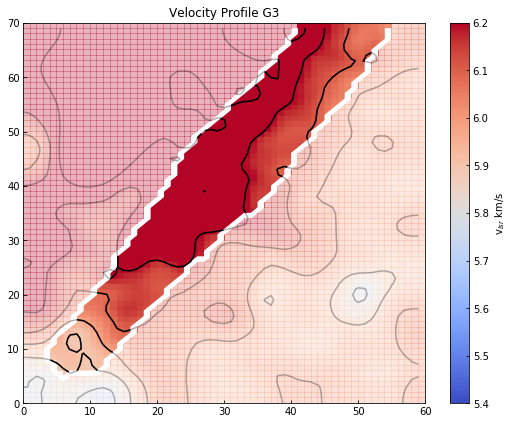

In [11]:
plt.figure(figsize=(9, 7))

levels=np.arange(5.4, 6.4, 0.1)

plt.pcolormesh(ls_gt*g3_velocity, cmap='coolwarm', vmin=5.4, vmax=6.2)
cbar = plt.colorbar()
plt.pcolormesh(g3_velocity, cmap='coolwarm', vmin=5.4, vmax=6.2 , alpha=0.3)
plt.contour(ls_maskt, colors='white')
plt.contour(ls_gt*g3_velocity, colors='black', levels=levels)
plt.contour(g3_velocity, colors='black', alpha=0.3, levels=levels)

plt.title('Velocity Profile G3')
cbar.set_label('v$_{lsr}$ km/s')
plt.show()


still some gradient, but much higher vel, all > 6.2

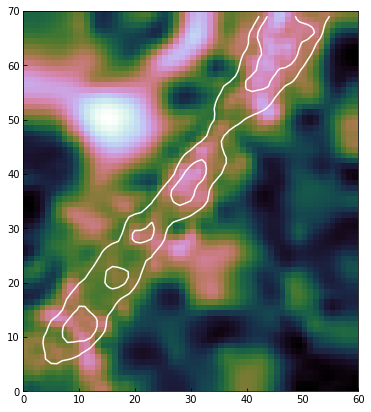

In [12]:
plt.figure(figsize=(6, 7))
plt.pcolormesh(g2_dispersion, cmap='cubehelix')
plt.contour(g2_intensity, colors='white', levels=[0.1, 0.2, 0.3, 0.4])

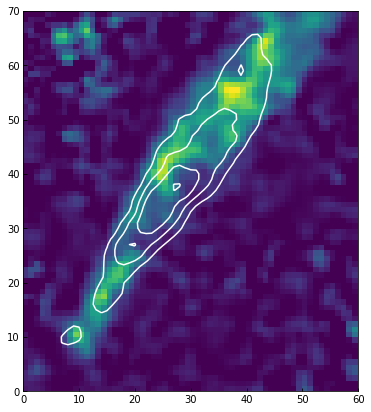

In [13]:
plt.figure(figsize=(6, 7))
plt.pcolormesh(g3_intensity)
#plt.contour(g2_intensity, colors='white', levels=[0.1, 0.2, 0.3, 0.4])
plt.contour(g1_intensity, colors='white', levels=[0.2, 0.4, 0.6, 0.8])

## Rotated Data Generator

In [31]:
angle=-35

g1_int_rot = ndimage.rotate(g1_intensity, angle, reshape=True)
g1_vel_rot = ndimage.rotate(g1_velocity, angle, reshape=True)
g1_dis_rot = ndimage.rotate(g1_dispersion, angle, reshape=True)
g2_int_rot = ndimage.rotate(g2_intensity, angle, reshape=True)
g2_vel_rot = ndimage.rotate(g2_velocity, angle, reshape=True)
g2_dis_rot = ndimage.rotate(g2_dispersion, angle, reshape=True)
g3_int_rot = ndimage.rotate(g3_intensity, angle, reshape=True)
g3_vel_rot = ndimage.rotate(g3_velocity, angle, reshape=True)
g3_dis_rot = ndimage.rotate(g3_dispersion, angle, reshape=True)

ls_mask1_rot = g1_int_rot > 0.03
g1_mask_rot = np.empty(ls_mask1_rot.shape)
g1_mask_rot.fill(np.nan)
g1_mask_rot[ls_mask1_rot == True] = 1

ls_mask2_rot = g2_int_rot > 0.08
g2_mask_rot = np.empty(ls_mask2_rot.shape)
g2_mask_rot.fill(np.nan)
g2_mask_rot[ls_mask2_rot == True] = 1

ls_mask3_rot = g1_int_rot > 0.05
g3_mask_rot = np.empty(ls_mask3_rot.shape)
g3_mask_rot.fill(np.nan)
g3_mask_rot[ls_mask3_rot == True] = 1

total_int_rot = g1_int_rot+g2_int_rot+g3_int_rot
ls_maskt_rot = total_int_rot > 0.16
tot_mask_rot = np.empty(ls_maskt_rot.shape)
tot_mask_rot.fill(np.nan)
tot_mask_rot[ls_maskt_rot == True] = 1

colden_re_rot = ndimage.rotate(colden_re, angle, reshape=True)

g1_norm = g1_int_rot/np.max(g1_int_rot)
g2_norm = g2_int_rot/np.max(g2_int_rot)
g3_norm = g3_int_rot/np.max(g3_int_rot)

colden_re_norm = colden_re_rot/np.max(colden_re_rot)

g1_mean = np.mean(g1_norm, axis=0)
g1_std = np.std(g1_norm, axis=0)
g2_mean = np.mean(g2_norm, axis=0)
g2_std = np.std(g2_norm, axis=0)
g3_mean = np.mean(g3_norm, axis=0)
g3_std = np.std(g3_norm, axis=0)

colden_mean = np.mean(colden_re_norm, axis=0)
colden_std = np.std(colden_re_norm, axis=0)

In [277]:
g1_box_mask = np.empty(g1_int_rot.shape)
g1_box_mask[:] = np.nan

for i in range(31, 49):
    for j in range(20, 79):
        g1_box_mask[j][i] = 1
        
g2_box_mask = np.empty(g2_int_rot.shape)
g2_box_mask[:] = np.nan

for i in range(35, 47):
    for j in range(20, 79):
        g2_box_mask[j][i] = 1
        
tip_box_mask = np.empty(g2_int_rot.shape)
tip_box_mask[:] = np.nan

for i in range(35, 48):
    for j in range(7, 27):
        tip_box_mask[j][i] = 1

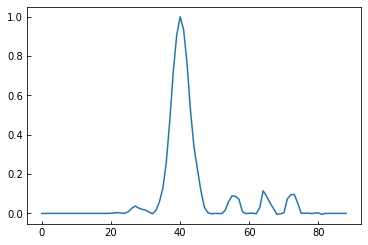

In [278]:
plt.plot(g1_int_rot[30]/np.max(g1_int_rot[30]))

In [32]:
g1_rot_mask = g1_int_rot > 0.1
g1_rot_cov = np.empty(g1_rot_mask.shape)
g1_rot_cov.fill(np.nan)
g1_rot_cov[g1_rot_mask == True] = 1

g2_rot_mask = g2_int_rot > 0.1
g2_rot_cov = np.empty(g2_rot_mask.shape)
g2_rot_cov.fill(np.nan)
g2_rot_cov[g2_rot_mask == True] = 1

In [280]:
(46-36)*pix_scale_au.to(u.pc)

<Quantity 0.05971937 pc>

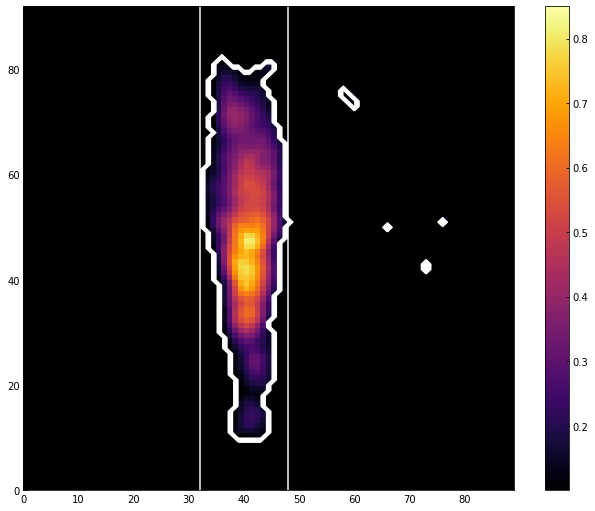

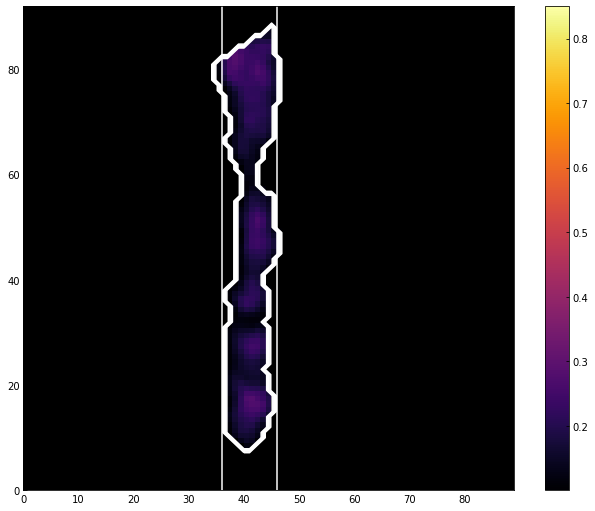

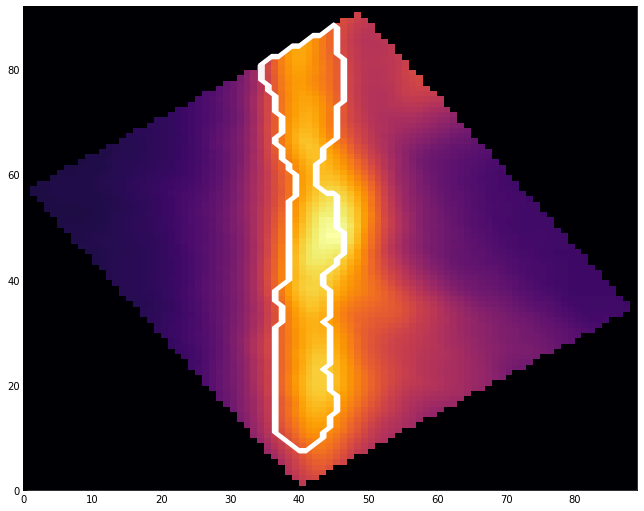

In [283]:
plt.figure(figsize=(g1_int_rot.shape[0]/10+1.8, g1_int_rot.shape[1]/10))
plt.pcolormesh(g1_rot_cov*g1_int_rot, cmap='inferno', vmax=0.85)
plt.colorbar()
plt.contour(g1_rot_mask, colors='white')
plt.axvline(32, color='white')
plt.axvline(48, color='white')

plt.show()
plt.figure(figsize=(g2_int_rot.shape[0]/10+1.8, g2_int_rot.shape[1]/10))
plt.pcolormesh(g2_rot_cov*g2_int_rot, cmap='inferno', vmax=0.85)
plt.colorbar()
plt.contour(g2_rot_mask, colors='white')
plt.axvline(36, color='white')
plt.axvline(46, color='white')

plt.show()
plt.figure(figsize=(colden_re_rot.shape[0]/10+1.8, colden_re_rot.shape[1]/10))
plt.pcolormesh(colden_re_rot, cmap='inferno')
#plt.contour(ls_maskt_rot, colors='white')
#plt.contour(g1_rot_mask, colors='white')
plt.contour(g2_rot_mask, colors='white')
plt.show()

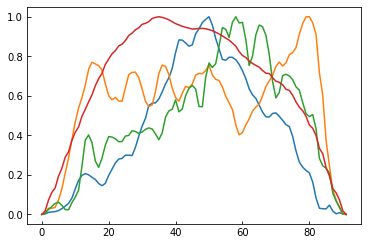

In [20]:
plt.plot(np.nanmean(g1_int_rot, axis=1)/np.nanmax(np.nanmean(g1_int_rot, axis=1)))
plt.plot(np.nanmean(g2_int_rot, axis=1)/np.nanmax(np.nanmean(g2_int_rot, axis=1)))
plt.plot(np.nanmean(g3_int_rot, axis=1)/np.nanmax(np.nanmean(g3_int_rot, axis=1)))
plt.plot(np.nanmean(colden_re_rot, axis=1)/np.nanmax(np.nanmean(colden_re_rot, axis=1)))

/Users/simonsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/simonsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/simonsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/simonsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/simonsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/simonsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':

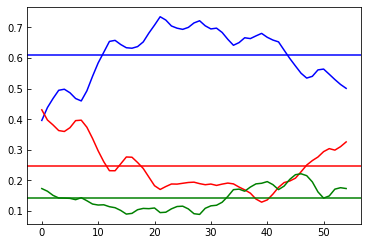

In [181]:
tot_profile = np.nanmean(g1_int_rot+g2_int_rot+g3_int_rot, axis=1)

plt.plot((np.nanmean(g1_int_rot, axis=1)/tot_profile)[20:75], color='blue')
plt.plot((np.nanmean(g2_int_rot, axis=1)/tot_profile)[20:75], color='red')
plt.plot((np.nanmean(g3_int_rot, axis=1)/tot_profile)[20:75], color='green')

plt.axhline(np.mean((np.nanmean(g1_int_rot, axis=1)/tot_profile)[20:75]), color='blue')
plt.axhline(np.mean((np.nanmean(g2_int_rot, axis=1)/tot_profile)[20:75]), color='red')
plt.axhline(np.mean((np.nanmean(g3_int_rot, axis=1)/tot_profile)[20:75]), color='green')

g1_ab = np.mean((np.nanmean(g1_int_rot, axis=1)/tot_profile)[20:75])
g2_ab = np.mean((np.nanmean(g2_int_rot, axis=1)/tot_profile)[20:75])
g3_ab = np.mean((np.nanmean(g3_int_rot, axis=1)/tot_profile)[20:75])
#plt.plot(np.nanmean(tot_profile, axis=1))

In [182]:
g1_ab+g2_ab+g3_ab

0.9999999999999999

In [190]:
acc_mass = []
for i in np.ravel(ls_maskt_rot*colden_re_rot):
    if i > 0:
        acc_mass.append(i)

In [195]:
(np.sum(acc_mass)*2*c.m_p/u.cm**2*pix_scale_au**2).to(u.M_sun)

<Quantity 6.31184578 solMass>

## Velocity Gradients from Rotated Data

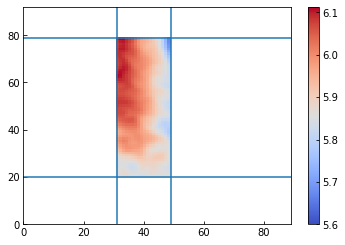

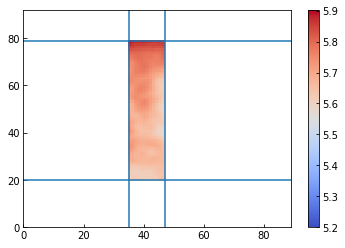

In [22]:
plt.pcolormesh(g1_box_mask*g1_vel_rot, cmap='coolwarm', vmin=5.6)
plt.colorbar()
plt.axvline(31)
plt.axvline(49)
plt.axhline(20)
plt.axhline(79)
plt.show()
plt.pcolormesh(g2_box_mask*g2_vel_rot, cmap='coolwarm', vmin=5.2)
plt.colorbar()
plt.axvline(35)
plt.axvline(47)
plt.axhline(20)
plt.axhline(79)
plt.show()

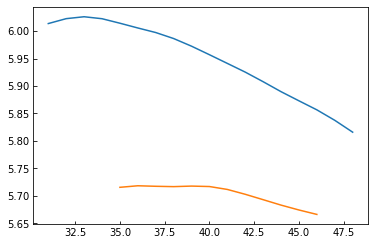

In [23]:
x1 = np.arange(31, 49)
x2 = np.arange(35, 47)

plt.plot(x1, np.nanmean(g1_vel_rot[20:79, 31:49], axis=0))
plt.plot(x2, np.nanmean(g2_vel_rot[20:79, 35:47], axis=0))
plt.show()

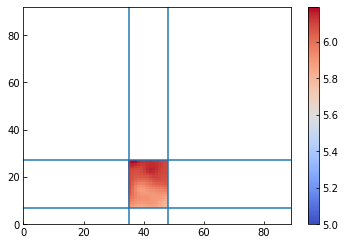

In [24]:
plt.pcolormesh(tip_box_mask*g3_vel_rot, cmap='coolwarm', vmin=5)
plt.colorbar()
plt.axvline(35)
plt.axvline(48)
plt.axhline(27)
plt.axhline(7)
plt.show()

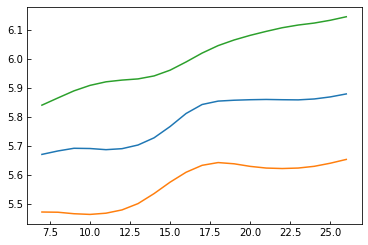

In [25]:
g1_tip_grad = np.mean(g1_vel_rot[7:27, 35:48], axis=1)
g2_tip_grad = np.mean(g2_vel_rot[7:27, 35:48], axis=1)
g3_tip_grad = np.mean(g3_vel_rot[7:27, 35:48], axis=1)

x_tip = np.arange(7, 27)

plt.plot(x_tip, g1_tip_grad)
plt.plot(x_tip, g2_tip_grad)
plt.plot(x_tip, g3_tip_grad)
plt.show()

### Compare velocity gradients in G1, G2

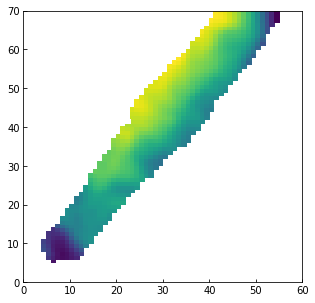

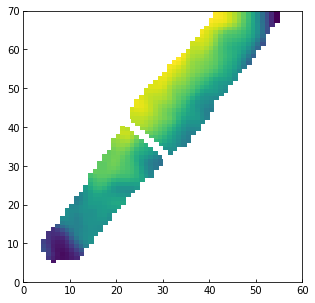

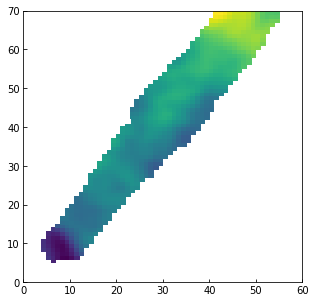

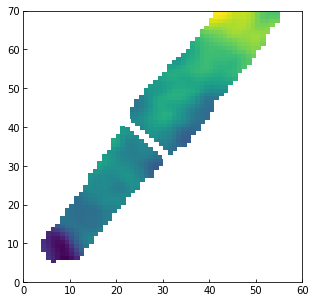

In [17]:
pt = [22, 41]
vg1 = r_mod.line_dec_inst(pt, ls_gt*g1_velocity, -1)
vg2 = r_mod.line_dec_inst(pt, ls_gt*g2_velocity, -1)

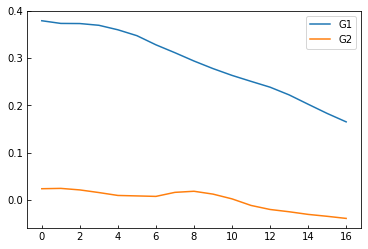

In [21]:
new_vg1 = line_comb(vg1)
new_vg2 = line_comb(vg2)
base = np.mean(new_vg2)

plt.plot(new_vg1 - base, label='G1')
plt.plot(new_vg2 - base, label='G2')

plt.legend()

plt.show()

## Temperature stability of core assuming 30% of total mass in region

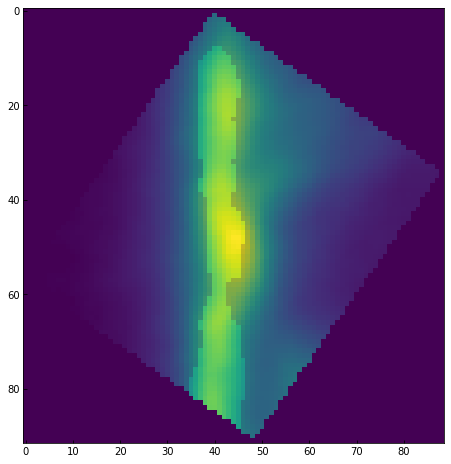

In [34]:
plt.figure(figsize=(8, 8))
plt.imshow(g2_rot_mask*colden_re_rot, vmin=np.min(colden_re))
plt.imshow(colden_re_rot, alpha=0.8, vmin=np.min(colden_re))

plt.show()

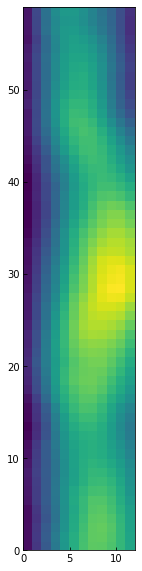

In [311]:
plt.figure(figsize=(2, 10))
plt.pcolormesh(colden_re_rot[20:79, 35:47])
plt.show()

In [347]:
T_g2 = np.sum(colden_re_rot[20:79, 35:47])/u.cm**2*0.3
L_g2 = (72-20)*pix_scale_au.to(u.pc)
N_g2 = (T_g2*pix_scale_au**2).decompose()
M_g2 = (N_g2*c.m_p).to(u.M_sun)

In [348]:
M_g2/L_g2

<Quantity 2.46444457 solMass / pc>

Working under the assumption that this is right, This means that the core weighs ~30% of the mass of the gas along this line of sight. It should be noted that this line of sight is somewhat thinner than the whole filament, which makes sense. The corse should be thinner. We took a thickness that accounts for a little more g2 than necessary meaning that the area use is an upper bound. Then, we divided n_g2/n_tot in that large region and found the average abundance of g2 was 30%. This would probably be an upper bound as the tips were where we saw the highest percentage. So, when we then reused this 30% term in a slightly smaller area, we are overestimating the percentage of the gas that is probably in g2. So 30% is an upper bound, and it is easily thermally supported.

### Cv analysis of G1

In [6]:
data = ls_gt
g1_edges = []
for i in range(30, len(data)):    
    pt_y = 0    
    for j in range(0, len(data[0])):        
        pt_x = 0        
        if np.isnan(data[i][j]) == False:            
            pt_x = j
            pt_y = i
            break
        else:            
            continue   
    g1_edges.append([pt_x, pt_y]) 

In [7]:
g1_edges

[[16, 30],
 [17, 31],
 [17, 32],
 [18, 33],
 [19, 34],
 [19, 35],
 [19, 36],
 [20, 37],
 [21, 38],
 [21, 39],
 [22, 40],
 [22, 41],
 [23, 42],
 [23, 43],
 [23, 44],
 [24, 45],
 [24, 46],
 [25, 47],
 [26, 48],
 [26, 49],
 [27, 50],
 [28, 51],
 [29, 52],
 [30, 53],
 [31, 54],
 [31, 55],
 [32, 56],
 [33, 57],
 [34, 58],
 [35, 59],
 [36, 60],
 [36, 61],
 [37, 62],
 [38, 63],
 [38, 64],
 [39, 65],
 [40, 66],
 [40, 67],
 [41, 68],
 [41, 69]]

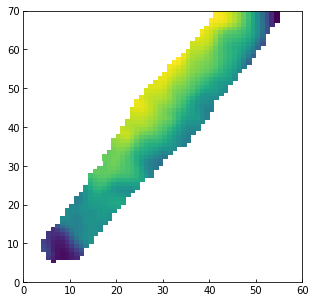

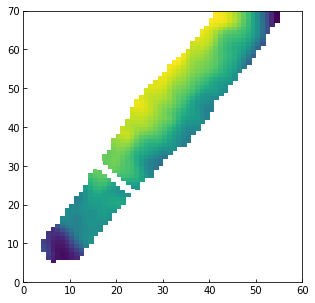

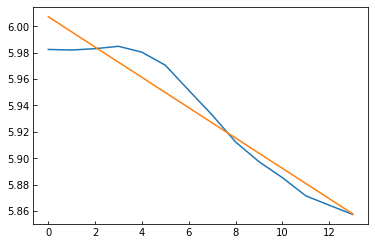

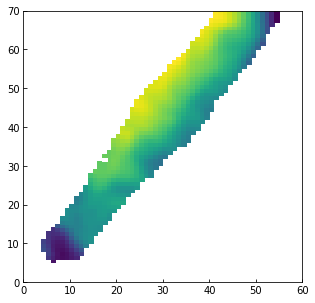

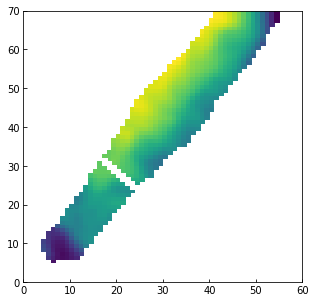

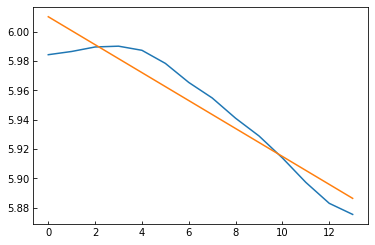

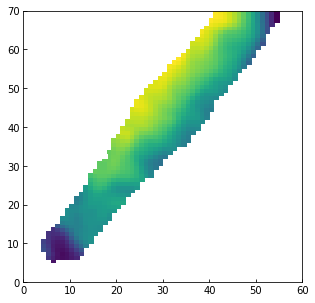

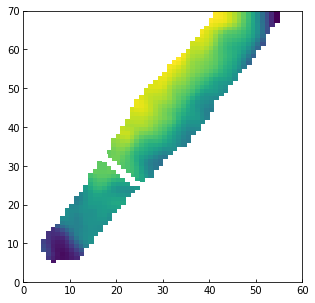

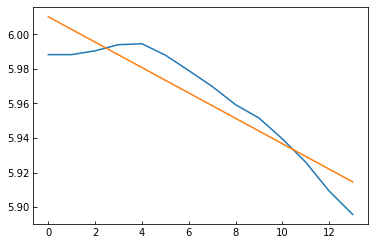

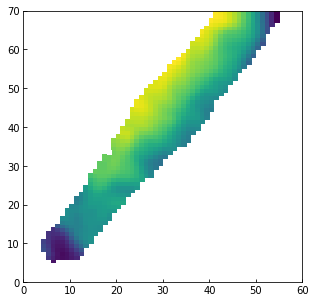

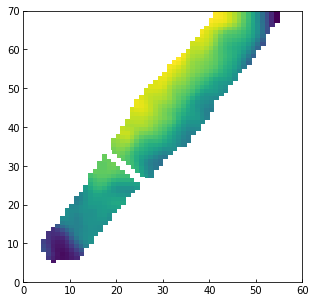

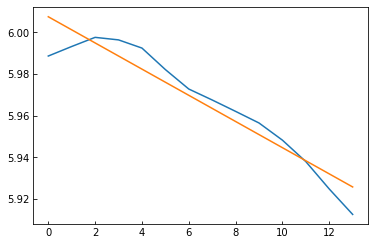

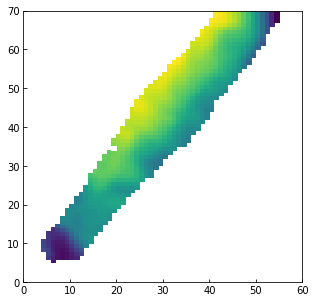

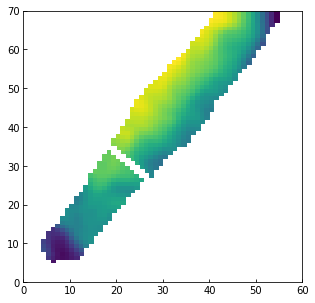

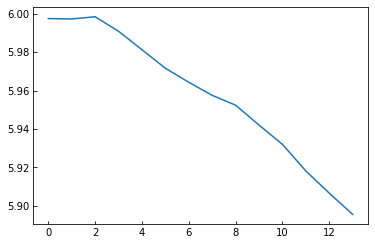

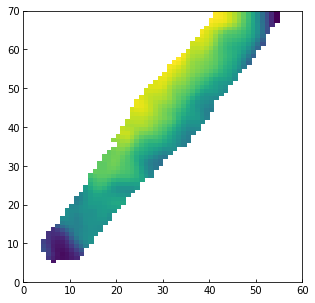

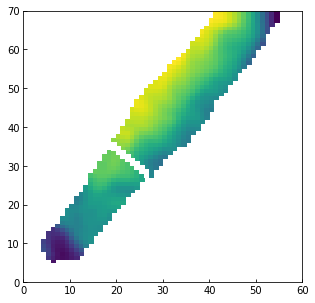

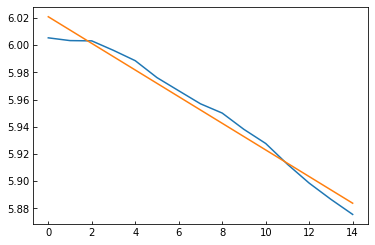

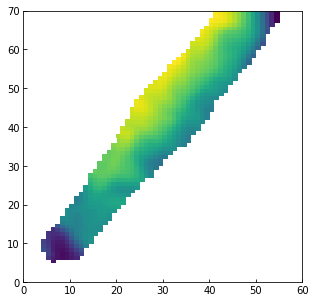

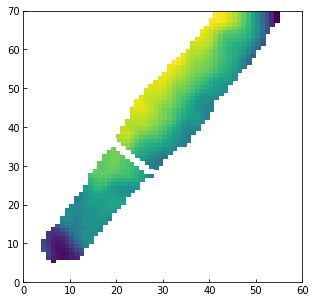

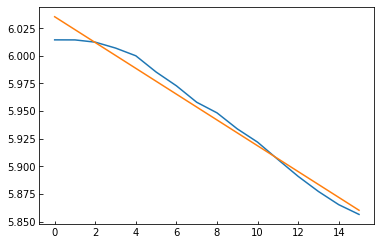

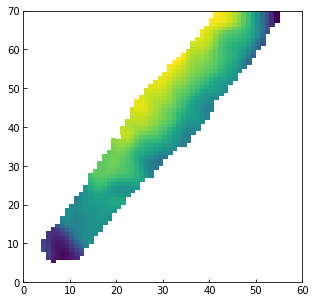

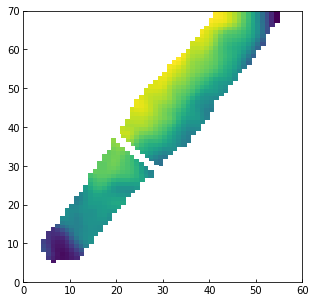

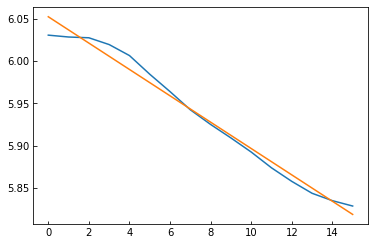

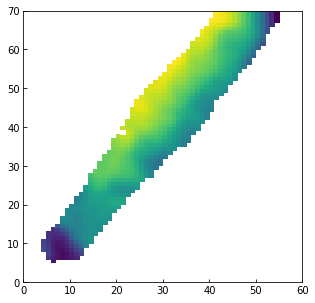

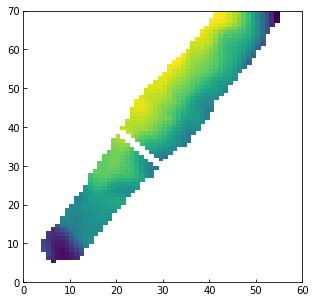

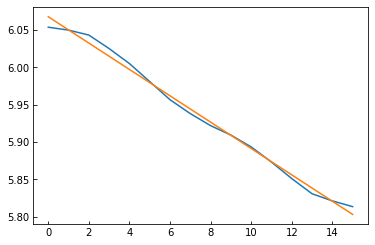

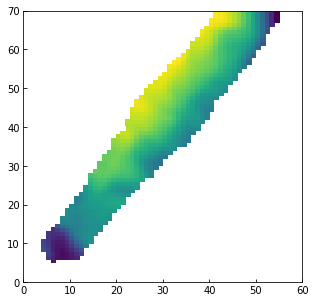

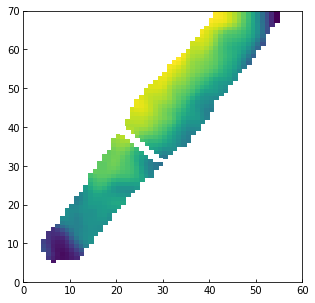

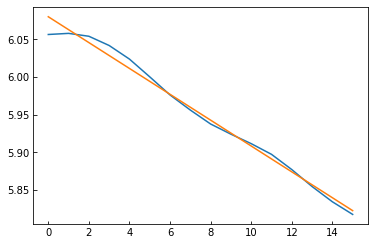

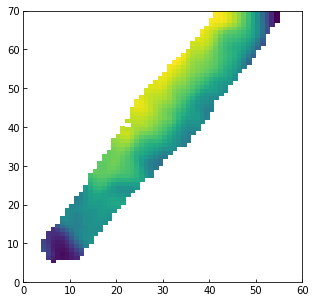

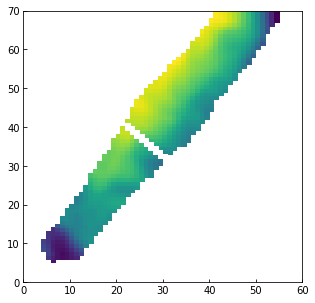

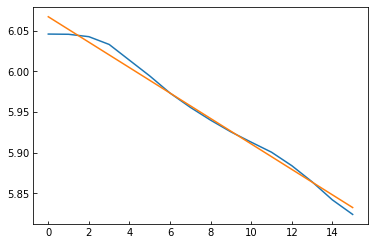

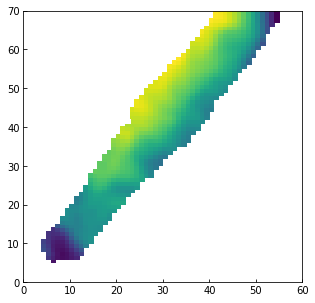

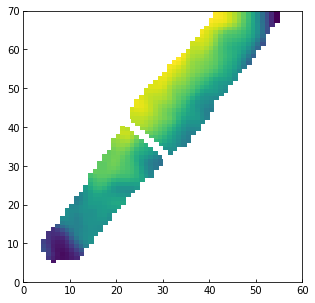

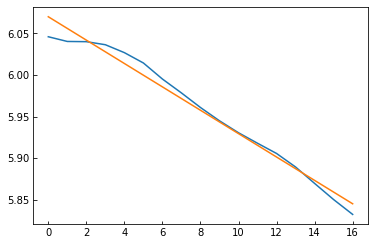

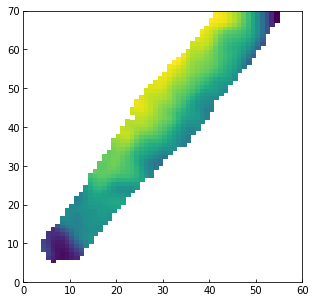

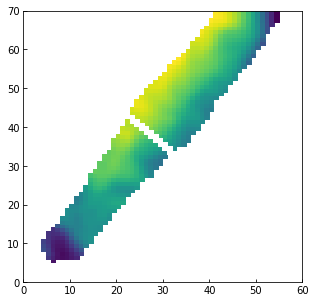

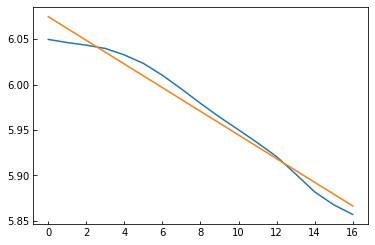

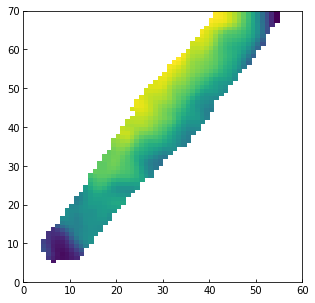

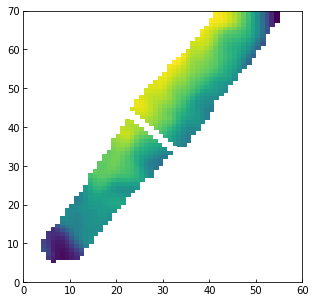

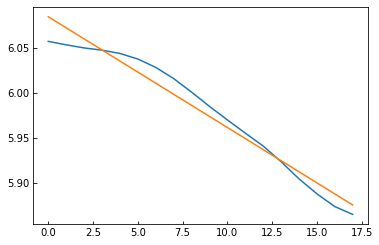

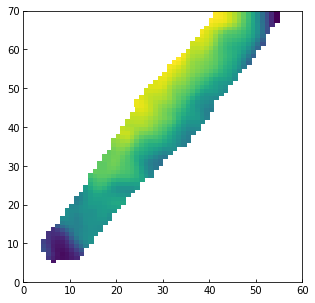

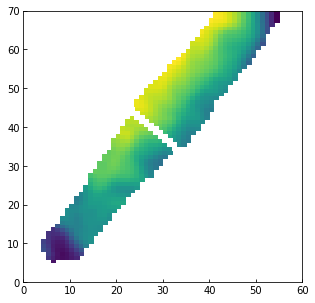

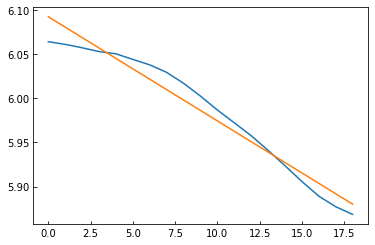

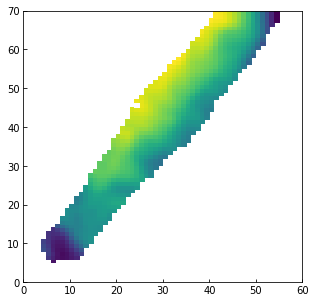

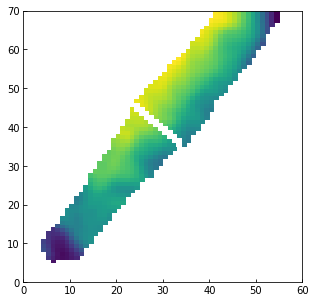

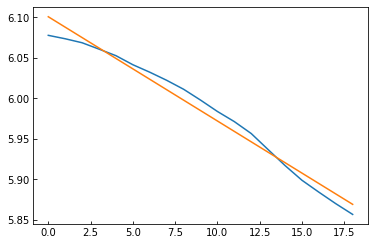

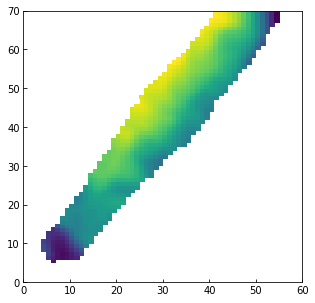

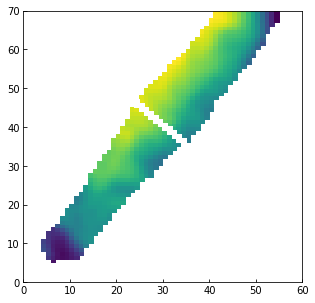

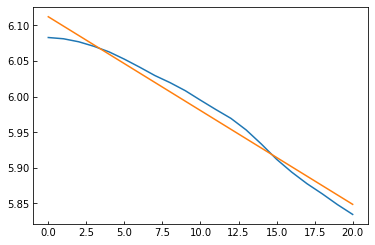

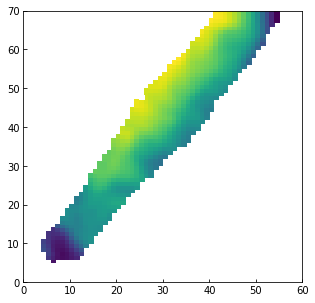

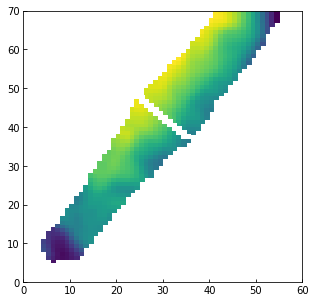

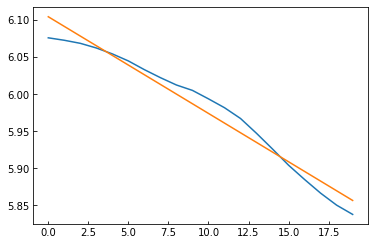

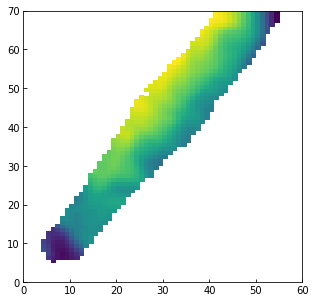

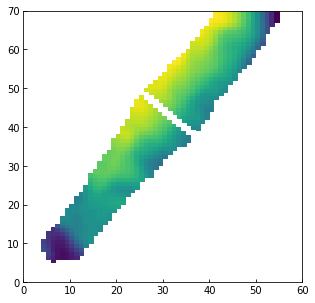

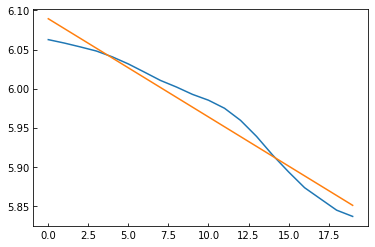

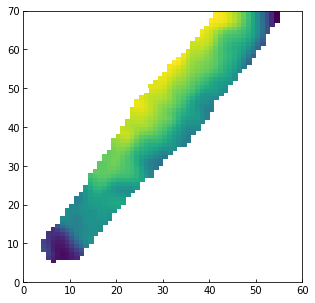

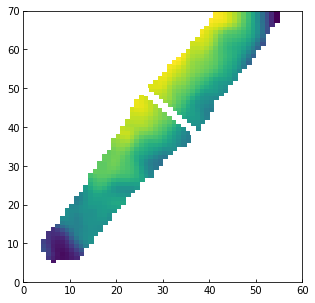

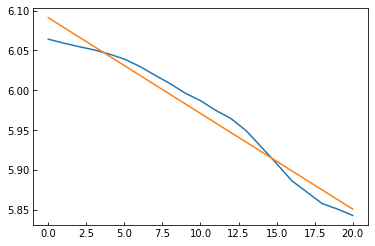

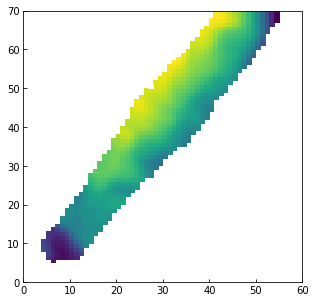

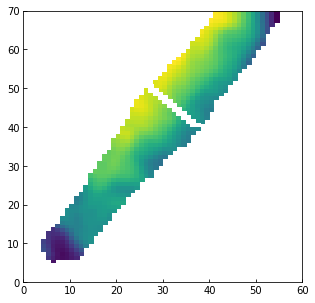

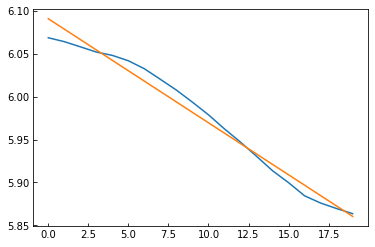

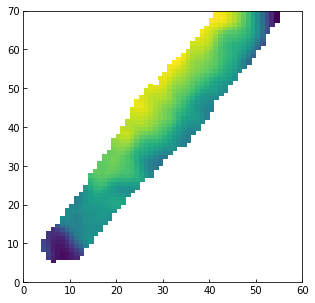

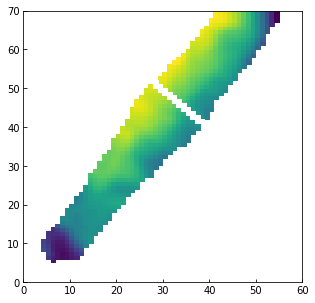

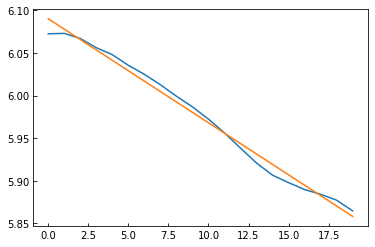

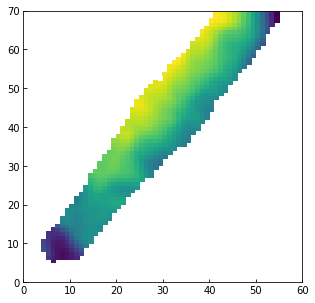

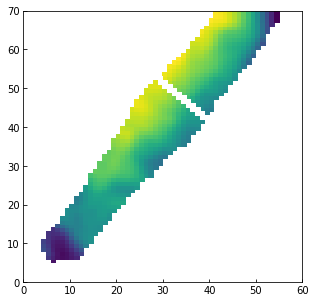

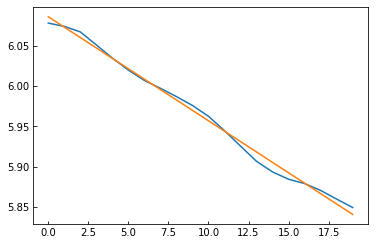

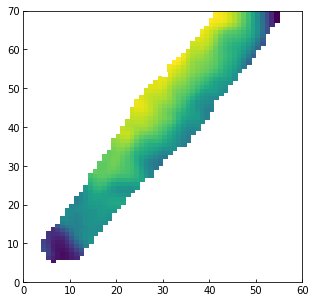

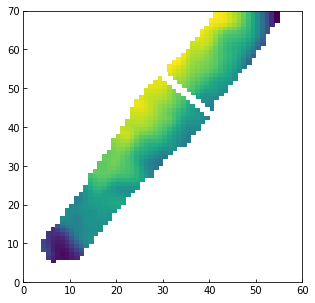

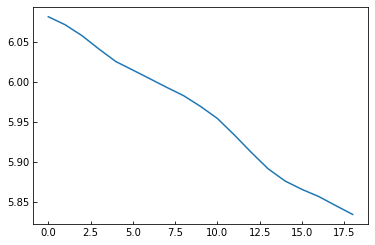

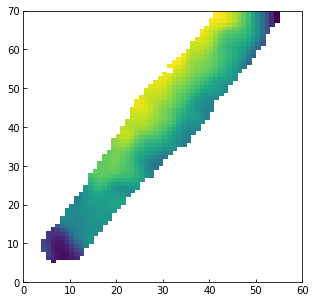

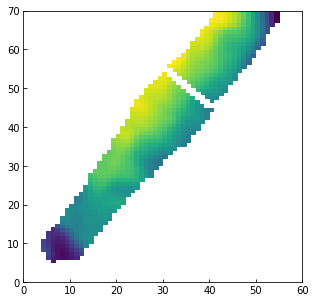

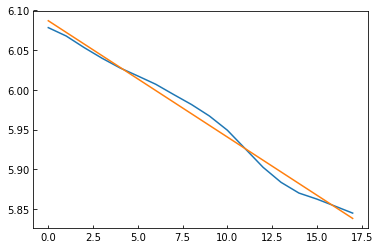

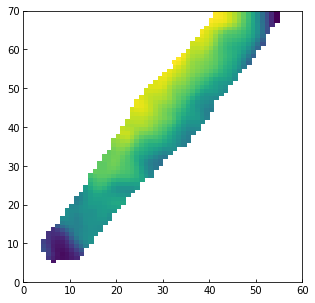

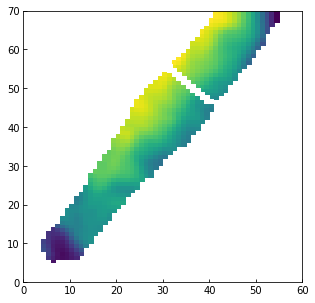

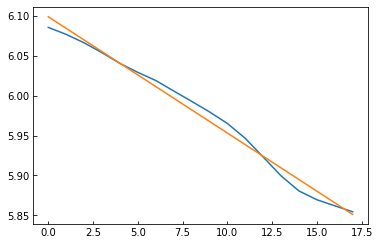

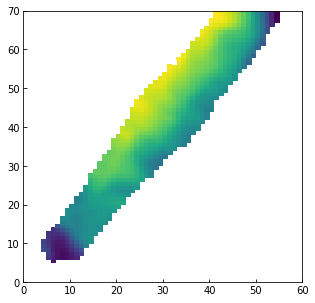

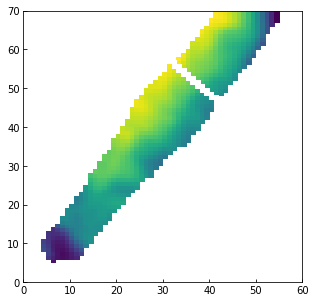

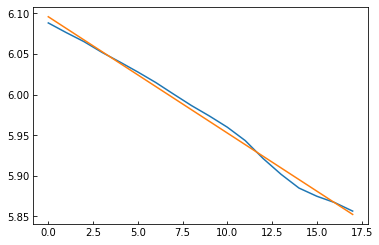

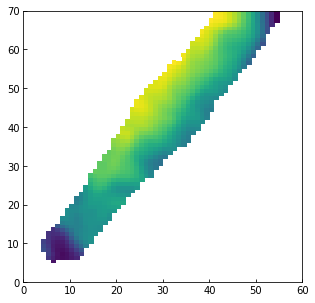

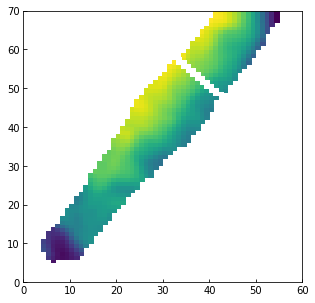

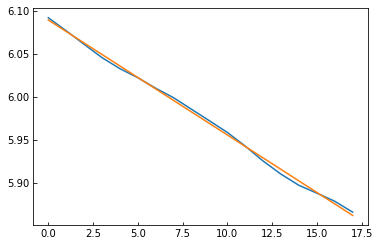

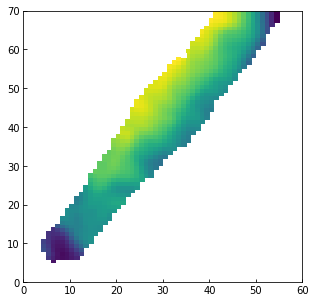

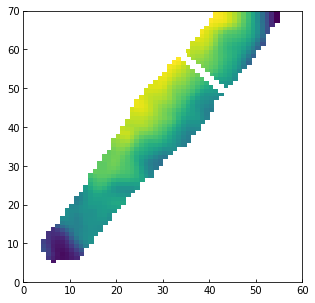

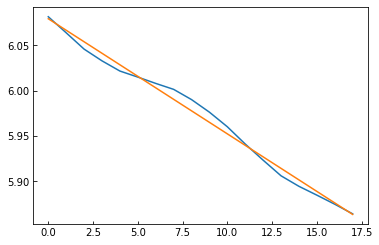

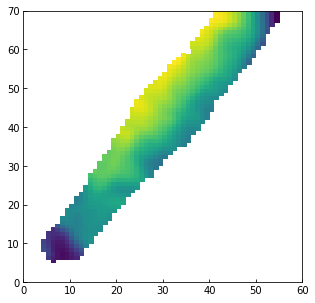

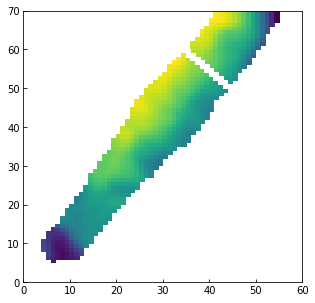

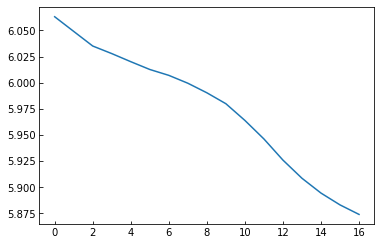

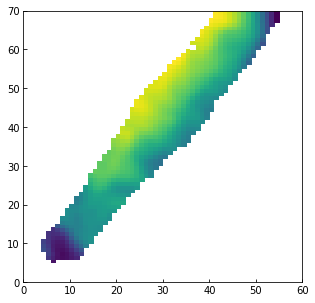

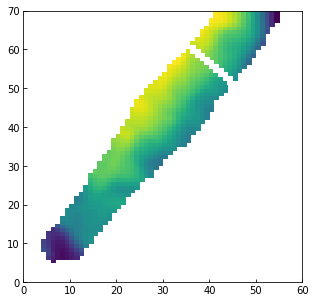

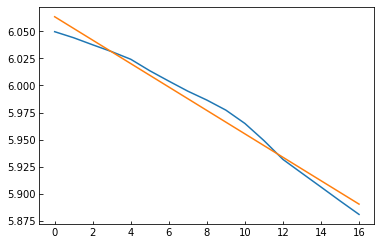

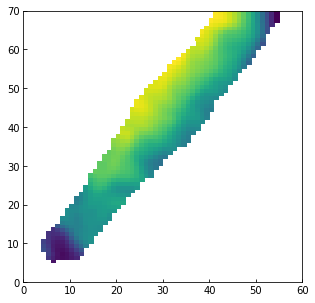

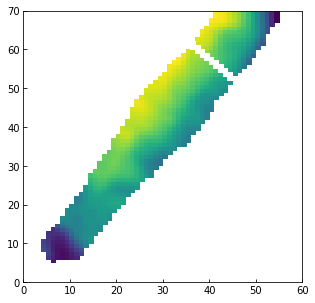

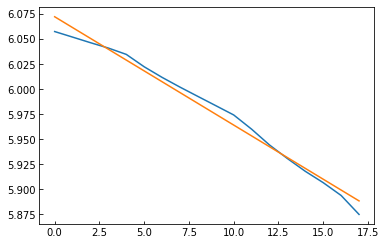

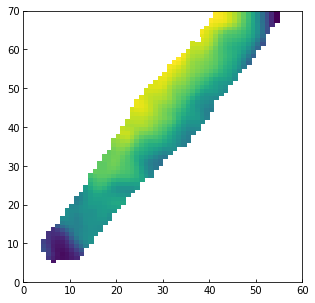

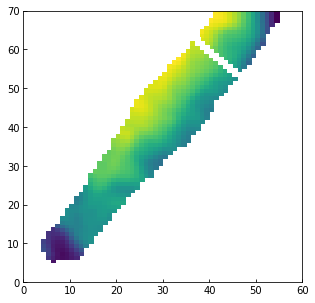

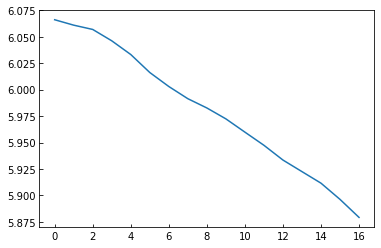

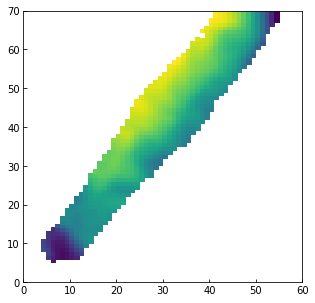

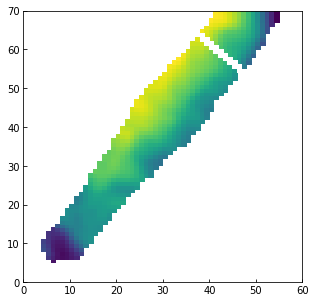

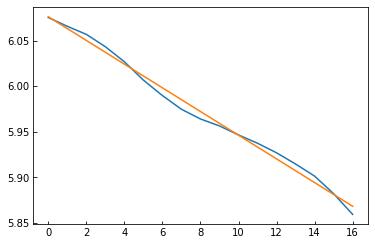

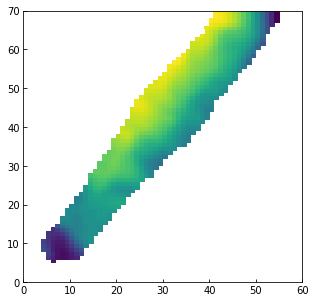

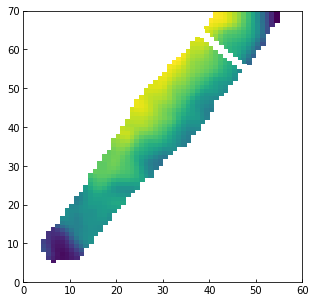

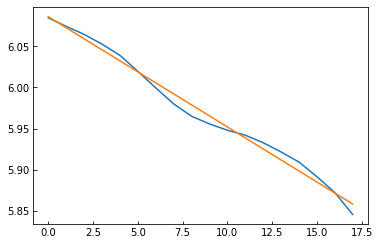

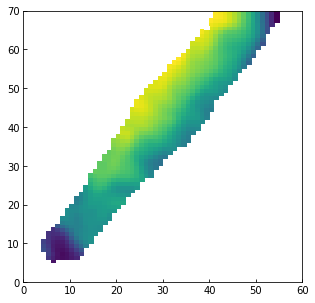

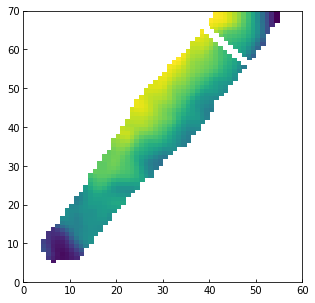

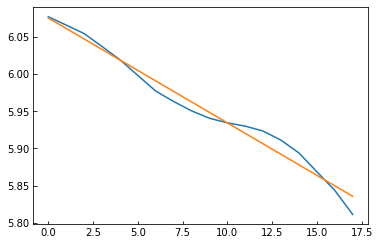

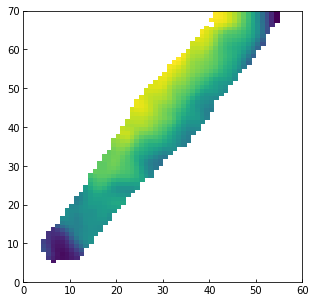

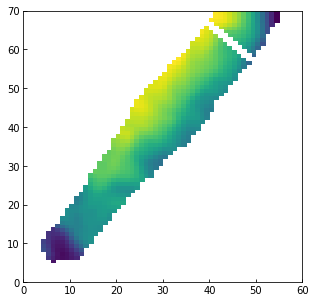

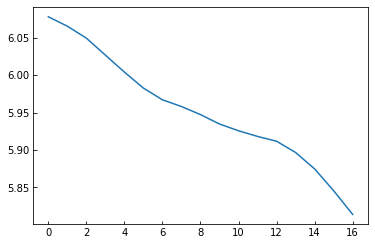

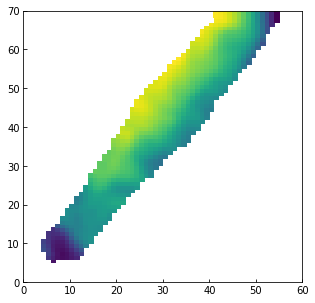

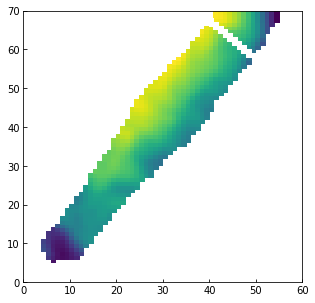

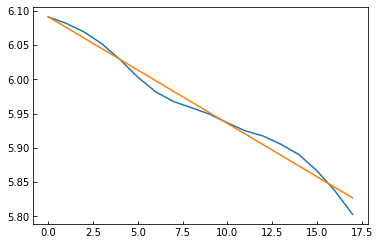

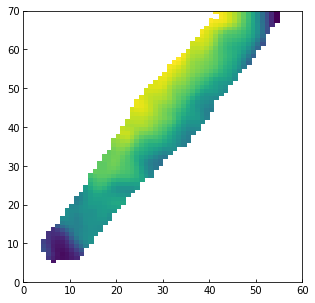

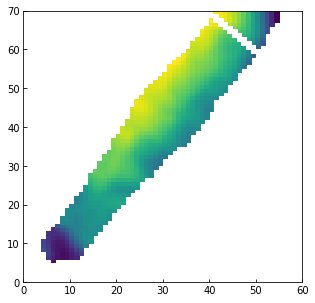

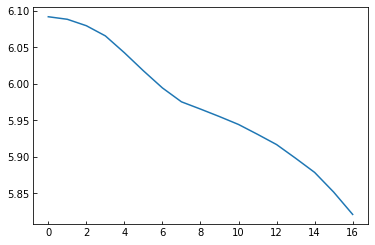

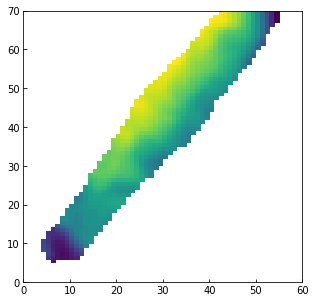

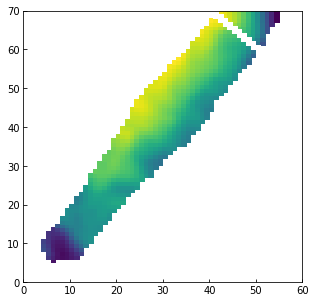

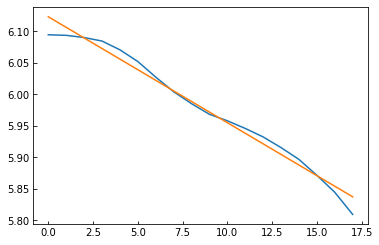

In [10]:
delta_v = []
for i in g1_edges:
    vel_grad = r_mod.line_dec_inst(i, ls_gt*g1_velocity, -1)
    new_vel_grad = line_comb(vel_grad)
    x = np.arange(0, len(new_vel_grad))
    plt.plot(x, new_vel_grad)
    m, b = np.polyfit(x, new_vel_grad, 1)
    plt.plot(x, m*x+b)
    delta_v.append(m*(35/2))

In [9]:
def line_comb(line):
    """
    Take two parallell lines and output averaged line.
    input length n, output length n-1
    """
    new_line = []
    for i in range(1, len(line)):
        new_line.append((line[i]+line[i-1])/2)
    new_line = np.array(new_line)
    return new_line

In [24]:
new_vel_grad = line_comb(vel_grad)

In [25]:
x = np.arange(0, len(new_vel_grad))

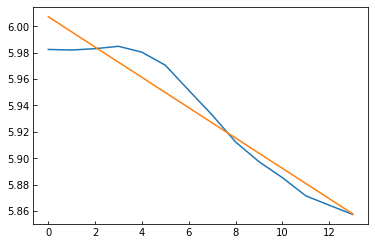

In [26]:
plt.plot(x, new_vel_grad)
m, b = np.polyfit(x, new_vel_grad, 1)
plt.plot(x, m*x+b)

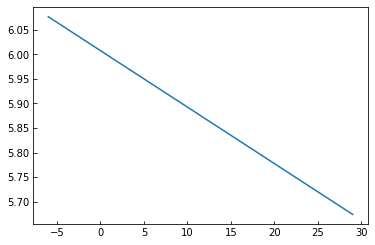

In [27]:
x2 = np.arange(-6, 30)
plt.plot(x2, m*x2+b)
extent = m*x2+b

In [18]:
l = 36
s = m

m*36/2

-0.23512220313985263

In [33]:
hv = (extent[0] - extent[-1])/2*u.km/u.s
M_L = 27.327773*u.M_sun/u.pc

In [78]:
C_v = hv**2/c.G/M_L

In [81]:
C_v.decompose()

<Quantity 0.44458319>

In [89]:
hv

<Quantity 0.22859103 km / s>

In [28]:
m*(35/2)

-0.20097565868889591

In [37]:
Cvs = ((np.array(delta_v)*u.km/u.s)**2/c.G/M_L).decompose()

In [39]:
np.nanmean(Cvs), np.nanstd(Cvs)

(<Quantity 0.44842443>, <Quantity 0.15759822>)

C$_v$ = 0.45+/-0.16

### Looking for faint emission outside of spike

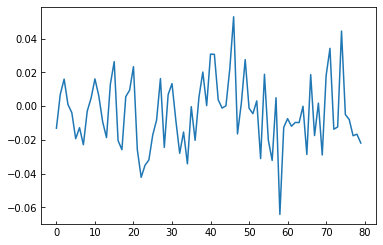

In [26]:
plt.plot(np.mean(np.mean(cube_data[:, :20, 40:], axis=2), axis=1))

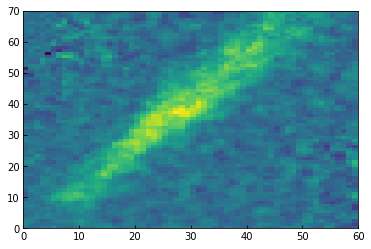

In [16]:
plt.pcolormesh(np.sum(cube_data[:, :, :], axis=0))

lack of emission off the filament indicates that the conditions are not condusive to HC$_5$N emission in the 9-8 rotational transition. Chemically, yes there could be polycarbon out there, but the density conditions are not exciting that particular rotational transition. We typically assume that a filament is either cylindrical in geometry, or lying in a sheet that is condensing along it's axis. Knowing that it seems to light up at relatively high density regions, this gives us good reason to think that we are looking at this filament closer to head on than side on and the H$_2$ density falls off fairly quickly off the main part of the filament.

In [13]:
data = pd.read_csv("TMC_cores.txt", sep=" ", header=None)
data.columns=["_idx", "area_ellipse", "area_exact", "flux", "major_sigma", "minor_sigma",
             "position_angle", "radius", "x_cen", "y_cen"]

In [14]:
data

_idx  area_ellipse    area_exact       flux  major_sigma  minor_sigma  \
0      0  15850.103601  40410.587905  13.610360    96.310511    37.788572   
1      4   1872.043022   5728.704033   5.163433    28.665739    14.995286   
2      7   2560.598252   8360.811291   7.493561    27.751046    21.186741   
3      8   3655.428691  11689.652823  12.292902    43.356975    19.358932   
4      9   4024.246169  11999.312501   4.293714    38.489310    24.007474   
5     10    477.726042   1316.053629   3.071132    19.378061     5.660707   
6     12   7967.793804  20205.293953   7.432046    52.135835    35.091652   
7     14   2027.016059   6270.608468   6.167605    27.935534    16.661047   
8     15   3311.782480   9367.205242  24.587580    69.157096    10.995807   
9     16    543.880831   1470.883468   1.033661    16.186328     7.715383   
10    17    988.534542   2477.277419   0.902226    17.487326    12.979875   
11    18   3670.722584  14708.834678  10.349593    38.708041    21.774713   
12    19   1260.531304   3483.671371   2.160846    20.403128    14.185967   
13    21   5392.485608  17650.601614  30.312816    55.344605    22.372564   
14    22    943.263364   2322.447581   2.480545    31.568543     6.860891   
15    24   1091.060715   3406.256452   4.912560    23.069942    10.859366   
16    25   1180.658849   3715.916129   5.842917    19.646848    13.798555   

    position_angle     radius      x_cen      y_cen  
0       158.582835  60.327744  70.127265  25.491310  
1        64.685436  20.732847  70.470446  25.640588  
2        72.717937  24.247767  69.929965  25.681487  
3        60.415907  28.971447  69.892228  25.691823  
4        92.864124  30.397880  69.974089  25.712695  
5        62.187952  10.473468  70.378966  25.764664  
6        52.406146  42.773036  69.895585  25.790449  
7      -155.327551  21.573948  70.305612  25.781901  
8      -139.473296  27.576042  70.337061  25.805521  
9        59.459312  11.175138  70.293898  25.801534  
10       78.307163  15.065965  69.857863  25.807915  
11       90.371891  29.031991  69.823454  25.866398  
12       93.021259  17.012880  70.253606  25.886457  
13       45.358619  35.188077  70.405338  26.009763  
14     -151.966344  14.716940  70.350369  26.035545  
15       49.293595  15.827980  69.881834  26.429875  
16       65.987735  16.465057  69.858453  26.448069

In [52]:
pix_scale_deg = tmc1.wcs.to_header()['CDELT2']
x_mid = tmc1.wcs.to_header()['CRVAL1']
y_mid = tmc1.wcs.to_header()['CRVAL2']
x_axis = 88
y_axis = 103

In [53]:
x_range = [x_mid-(x_axis/2*pix_scale_deg), x_mid+(x_axis/2*pix_scale_deg)]
y_range = [y_mid-(y_axis/2*pix_scale_deg), y_mid+(y_axis/2*pix_scale_deg)]

In [57]:
x_range

[69.26324558211064, 69.40991224877735]

In [58]:
tmc1.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 69.33657891544411  26.026109792652093  
CRPIX : 634.0  256.0  
NAXIS : 88  103

## Mass Accretion rate

this will involve getting an estimate for the amount of mass within the "moving" part of the the HC5N and also estimating our relative line of sight with the plane of accretion.

## Velocity Gradient across core for declining abundance from -x,-y to +x,+y

First try is an over simplification where we only use the values at the edge of the circle

In [69]:
theta = np.arange(0, np.pi/2+np.pi/24, np.pi/24)[:-1][::-1]
x = np.cos(theta)
A = 10 # this represents the abundance, ie the amount of HC5N particles emitting in that pixel.
E = 1/4*np.sin(theta)

In [70]:
E

array([0.25      , 0.24786122, 0.24148146, 0.23096988, 0.21650635,
       0.19833834, 0.1767767 , 0.15219036, 0.125     , 0.09567086,
       0.06470476, 0.03263155, 0.        ])

(-1.05, 1.05)

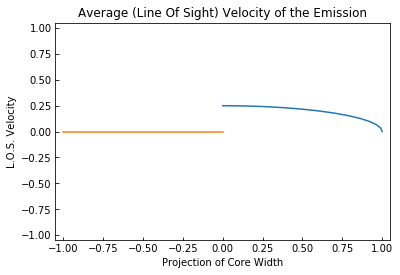

In [71]:
plt.plot(x, E)
plt.plot(-1*x[::-1], np.zeros(len(x)))
plt.xlabel("Projection of Core Width")
plt.ylabel("L.O.S. Velocity")
plt.title("Average (Line Of Sight) Velocity of the Emission")

plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)

^This just ended up being totally wrong btw

quick detour to learn vectors

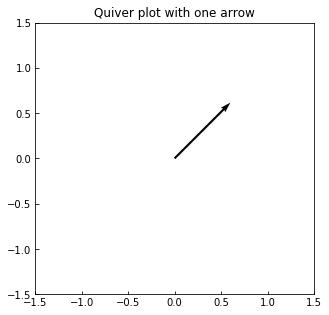

In [97]:
plt.figure(figsize=(5, 5))

x_pos = 0
y_pos = 0
x_direct = 1
y_direct = 1

plt.quiver(x_pos, y_pos, x_direct, y_direct, scale=5)
plt.title('Quiver plot with one arrow')
plt.axis([-1.5, 1.5, -1.5, 1.5])


plt.show()


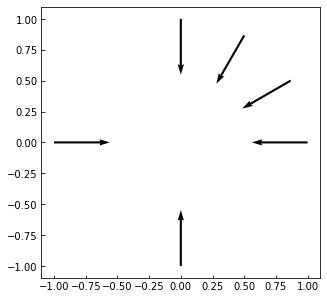

In [105]:
plt.figure(figsize=(5, 5))

x_pos = np.array([0, 1, 0, -1, 1/2, np.sqrt(3)/2])
y_pos = np.array([1, 0, -1, 0, np.sqrt(3)/2, 1/2])
x_direct = -x_pos
y_direct = -y_pos

plt.quiver(x_pos, y_pos, x_direct, y_direct, scale=5)

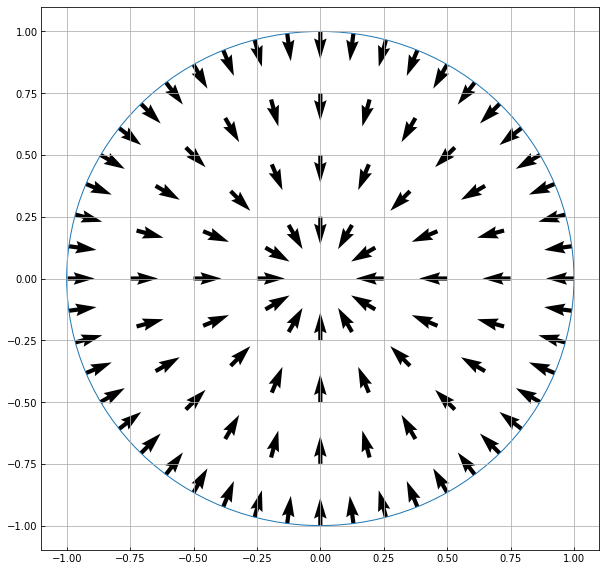

In [138]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
circle = plt.Circle((0,0), 1, fill=False, color='tab:blue')


r = 1
theta = np.arange(0, 2*np.pi, np.pi/24)
x_pos = r*np.cos(theta)
y_pos = r*np.sin(theta)
x_direct = -x_pos
y_direct = -y_pos
ax.quiver(x_pos, y_pos, x_direct, y_direct, scale=20)

r = 0.75
theta = np.arange(0, 2*np.pi, np.pi/12)
x_pos = r*np.cos(theta)
y_pos = r*np.sin(theta)
x_direct = -x_pos/r
y_direct = -y_pos/r
ax.quiver(x_pos, y_pos, x_direct, y_direct, scale=20)

r = 0.5
theta = np.arange(0, 2*np.pi, np.pi/8)
x_pos = r*np.cos(theta)
y_pos = r*np.sin(theta)
x_direct = -x_pos/r
y_direct = -y_pos/r
ax.quiver(x_pos, y_pos, x_direct, y_direct, scale=20)

r = 0.25
theta = np.arange(0, 2*np.pi, np.pi/6)
x_pos = r*np.cos(theta)
y_pos = r*np.sin(theta)
x_direct = -x_pos/r
y_direct = -y_pos/r
ax.quiver(x_pos, y_pos, x_direct, y_direct, scale=20)

ax.add_patch(circle)
ax.grid(True)
plt.show()

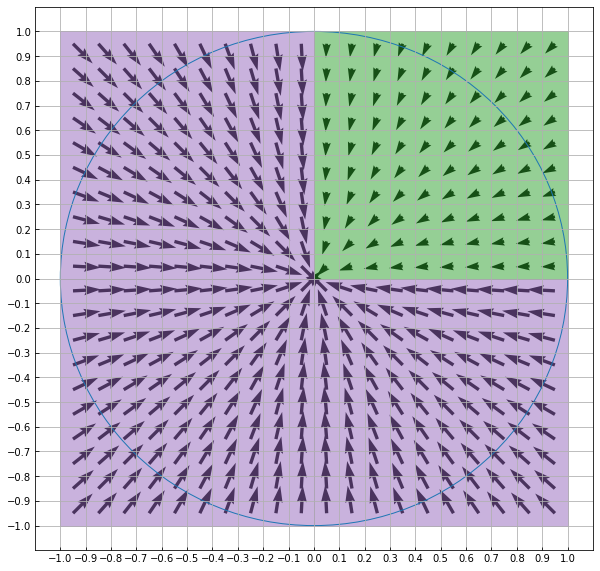

In [194]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
circle = plt.Circle((0,0), 1, fill=False, color='tab:blue')
square1 = plt.Rectangle((0, 0), 1, 1, fill=True, color='tab:green', alpha=0.5)
square2 = plt.Rectangle((0, 0), -1, 1, fill=True, color='tab:purple', alpha=0.5)
square3 = plt.Rectangle((0, 0), -1, -1, fill=True, color='tab:purple', alpha=0.5)
square4 = plt.Rectangle((0, 0), 1, -1, fill=True, color='tab:purple', alpha=0.5)

ax.set_xticks(np.arange(-1.0, 1.1, 0.1))
ax.set_yticks(np.arange(-1.0, 1.1, 0.1))
ax.xaxis.grid(True)
ax.yaxis.grid(True)

ax.add_patch(square1)
ax.add_patch(square2)
ax.add_patch(square3)
ax.add_patch(square4)
ax.add_patch(circle)

#Quadrant 1

x_dots1 = np.arange(0.05, 1.05, 0.1)
y_dots1 = np.arange(0.05, 1.05, 0.1)
X_dots1, Y_dots1 = np.meshgrid(x_dots1, y_dots1)
r1 = np.sqrt(X_dots1**2+Y_dots1**2)*2
ax.quiver(X_dots1, Y_dots1, -X_dots1/r1, -Y_dots1/r1, scale=20)

#Quadrant 2

x_dots2 = np.arange(-0.95, 0.05, 0.1)
y_dots2 = np.arange(0.05, 1.05, 0.1)
X_dots2, Y_dots2 = np.meshgrid(x_dots2, y_dots2)
r2 = np.sqrt(X_dots2**2+Y_dots2**2)
ax.quiver(X_dots2, Y_dots2, -X_dots2/r2, -Y_dots2/r2, scale=20)

#Quadrant 3

x_dots3 = np.arange(-0.95, 0.05, 0.1)
y_dots3 = np.arange(-0.95, 0.05, 0.1)
X_dots3, Y_dots3 = np.meshgrid(x_dots3, y_dots3)
r3 = np.sqrt(X_dots3**2+Y_dots3**2)
ax.quiver(X_dots3, Y_dots3, -X_dots3/r3, -Y_dots3/r3, scale=20)

#Quadrant 4

x_dots4 = np.arange(0.05, 1.05, 0.1)
y_dots4 = np.arange(-0.95, 0.05, 0.1)
X_dots4, Y_dots4 = np.meshgrid(x_dots4, y_dots4)
r4 = np.sqrt(X_dots4**2+Y_dots4**2)
ax.quiver(X_dots4, Y_dots4, -X_dots4/r4, -Y_dots4/r4, scale=20)



ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)

plt.show()

In [175]:
X_dots[0][0], Y_dots[0][0]

(-0.95, -0.95)

(array([1., 1., 1., 1., 6.]),
 array([0.14142136, 0.30080571, 0.46019006, 0.61957441, 0.77895876,
        0.93834312]),
 <a list of 5 Patch objects>)

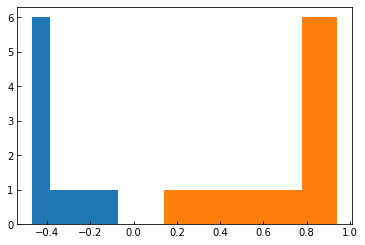

In [213]:
plt.hist(-Y_dots1[:, 3]/r1[:, 3], bins='auto')
plt.hist(-Y_dots4[:, 3]/r4[:, 3], bins='auto')


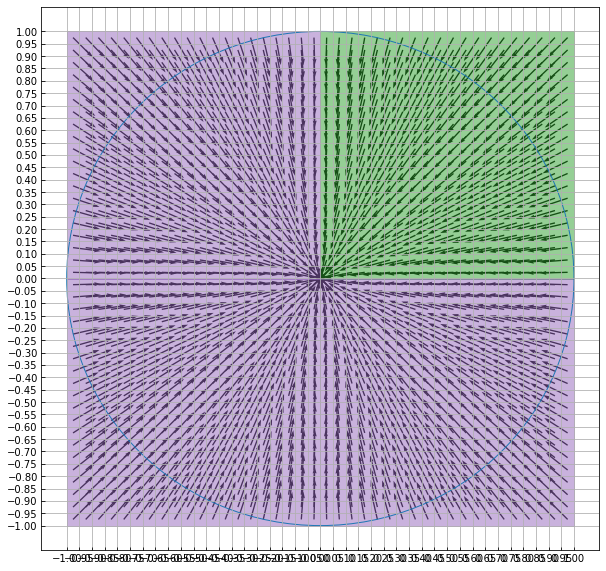

In [272]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
circle = plt.Circle((0,0), 1, fill=False, color='tab:blue')
square1 = plt.Rectangle((0, 0), 1, 1, fill=True, color='tab:green', alpha=0.5)
square2 = plt.Rectangle((0, 0), -1, 1, fill=True, color='tab:purple', alpha=0.5)
square3 = plt.Rectangle((0, 0), -1, -1, fill=True, color='tab:purple', alpha=0.5)
square4 = plt.Rectangle((0, 0), 1, -1, fill=True, color='tab:purple', alpha=0.5)

ax.set_xticks(np.arange(-1.0, 1.05, 0.05))
ax.set_yticks(np.arange(-1.0, 1.05, 0.05))
ax.xaxis.grid(True)
ax.yaxis.grid(True)

ax.add_patch(square1)
ax.add_patch(square2)
ax.add_patch(square3)
ax.add_patch(square4)
ax.add_patch(circle)

#Quadrant 1

x_dots = np.arange(-0.975, 1.025, 0.05)
y_dots = np.arange(-0.975, 1.025, 0.05)
X_dots, Y_dots = np.meshgrid(x_dots, y_dots)
r = np.sqrt(X_dots**2+Y_dots**2)
x_vec = -X_dots/r
y_vec = -Y_dots/r
ax.quiver(X_dots, Y_dots, x_vec, y_vec, scale=20)

plt.show()

In [265]:
y_vec[:, 10]

array([ 0.99861783,  0.99827437,  0.99778516,  0.99705449,  0.99589321,
        0.99388373,  0.98994949,  0.98058068,  0.9486833 ,  0.70710678,
       -0.70710678, -0.9486833 , -0.98058068, -0.98994949, -0.99388373,
       -0.99589321, -0.99705449, -0.99778516, -0.99827437, -0.99861783])

In [273]:
def pixel_los_half(pixel):
    """
    Calculate the average line of sight velocity for the desired pixel given Quadrant 1 
    only has half the abundance of HC5N. Work with "full" abundance as 10 particles.
    
    Only pixels to the right of the core centre should given an los different than 0.
    """
    
    if pixel < 20:
        return np.round(np.mean(y_vec[:, pixel]))
    else:
        los_hist = []
        for i in y_vec[:20, pixel]:
            for j in range(0, 100):
                los_hist.append(i)

        for i in y_vec[20:, pixel]:
            for j in range(0, 50):
                los_hist.append(i)
        return np.mean(los_hist)

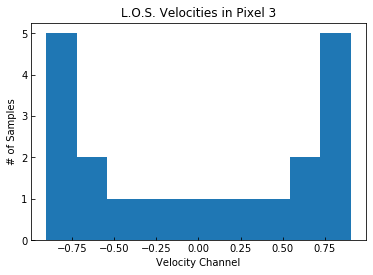

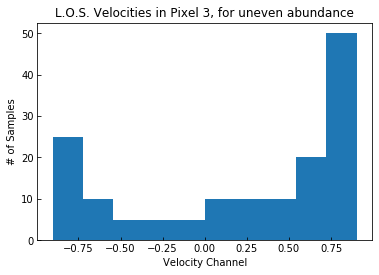

0.21581725965906778


In [247]:
pixel = 5

los_hist = []
for i in y_vec[:10, pixel]:
    for j in range(0, 10):
        los_hist.append(i)
        
for i in y_vec[10:, pixel]:
    for j in range(0, 5):
        los_hist.append(i)

plt.hist(y_vec[:, pixel], bins=10)
plt.title('L.O.S. Velocities in Pixel 3')
plt.xlabel('Velocity Channel')
plt.ylabel('# of Samples')
plt.show()

plt.hist(los_hist)
plt.title('L.O.S. Velocities in Pixel 3, for uneven abundance')
plt.xlabel('Velocity Channel')
plt.ylabel('# of Samples')
plt.show()

print(np.mean(los_hist))

In [274]:
los_slope = []
for i in range(0, 40):
    los_slope.append(pixel_los_half(i))

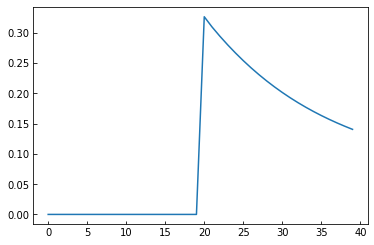

In [275]:
plt.plot(los_slope)

Doesnt quite work... Now, to test, need to define relative abundance with respect to distant from the centre of the core. Find this from the data with the core diameter as G2. Each square is given an abundance designation. Squares off of the core are desgnated zero.